In [50]:
import os
import pandas as pd
import numpy as np
from pandas.core.dtypes.common import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [52]:
df = pd.read_csv(DATASET)

possible_targets = [col for col in df.columns if not is_numeric_dtype(df[col])]
df[possible_targets]

vocal_channel  emotion emotional_intensity                     statement  \
0           speech  neutral              normal  Kids are talking by the door   
1           speech  neutral              normal  Kids are talking by the door   
2           speech  neutral              normal  Dogs are sitting by the door   
3           speech  neutral              normal  Dogs are sitting by the door   
4           speech     calm              normal  Kids are talking by the door   
...            ...      ...                 ...                           ...   
2424          song  fearful              normal  Dogs are sitting by the door   
2425          song  fearful              strong  Kids are talking by the door   
2426          song  fearful              strong  Kids are talking by the door   
2427          song  fearful              strong  Dogs are sitting by the door   
2428          song  fearful              strong  Dogs are sitting by the door   

     repetition     actor sex  
0           1st   actor_1   M  
1           2nd   actor_1   M  
2           1st   actor_1   M  
3           2nd   actor_1   M  
4           1st   actor_1   M  
...         ...       ...  ..  
2424        2nd  actor_24   F  
2425        1st  actor_24   F  
2426        2nd  actor_24   F  
2427        1st  actor_24   F  
2428        2nd  actor_24   F  

[2429 rows x 7 columns]

In [53]:
TARGET_COLUMN = 'vocal_channel'

In [54]:
values = df[TARGET_COLUMN].unique().tolist()
values

['speech', 'song']

In [55]:
one_hot = pd.get_dummies(df[TARGET_COLUMN])
df = df.join(one_hot)
df = df.drop([TARGET_COLUMN], axis=1)

In [56]:
def plot_percentage(data, columns):
    ones_percentage = [data[col].mean() * 100 for col in columns]

    plt.figure(figsize=(10, 6))
    plt.bar(columns, ones_percentage)
    plt.xlabel('Columns')
    plt.ylabel('Percentage of ones')
    plt.title('Percentage of ones in each column')
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.yticks(range(0, 101, 10))  # increments of 10 along the y-axis
    plt.show()

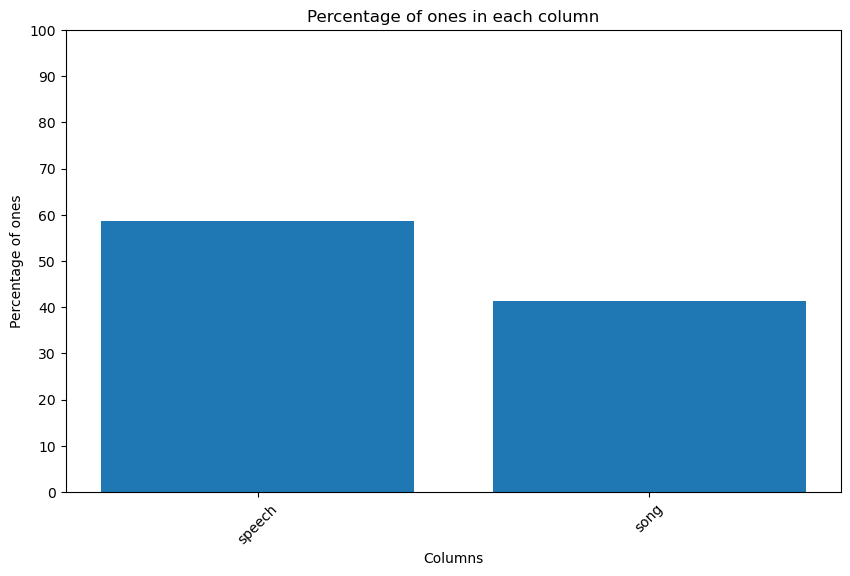

In [57]:
plot_percentage(df, values)

## Visualize the target class

In [58]:
TARGET_CLASS = 'song'

In [59]:
from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler

def isomap_by_class(data, values_list, value):

    data2 = data.drop(values_list, axis=1)
    X_scaled = MinMaxScaler().fit_transform(data2)

    isomap = Isomap(n_components=2)
    embedding = isomap.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=data[value], cmap='viridis')
    plt.xlabel('First component')
    plt.ylabel('Second component')
    plt.title(f'Scatterplot of {value} attribute using Isomap')
    plt.show()

In [60]:
from sklearn.decomposition import PCA

def pca_by_class(data, values_list, value):

    data2 = data.drop(values_list, axis=1)
    X_scaled = MinMaxScaler().fit_transform(data2)

    pca = PCA(n_components=2)
    embedding = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=data[value], cmap='viridis')
    plt.xlabel('First component')
    plt.ylabel('Second component')
    plt.title(f'Scatterplot of {value} attribute using PCA')
    plt.show()

In [61]:
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

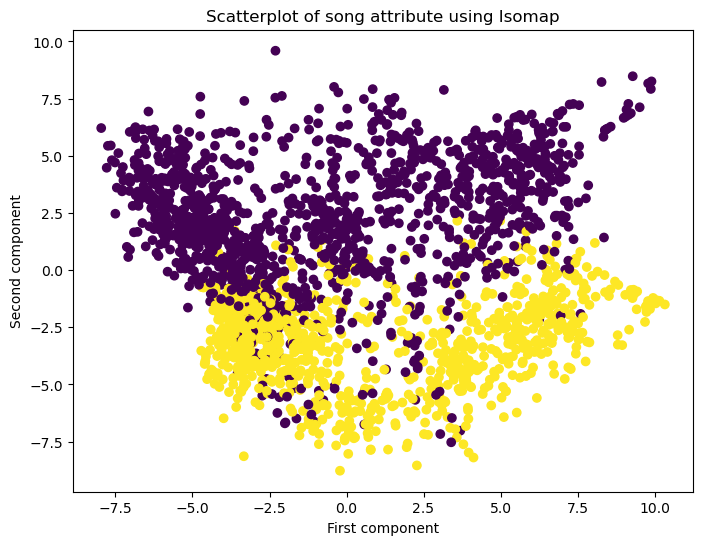

In [62]:
isomap_by_class(df[numerical_attr_list], values, TARGET_CLASS)

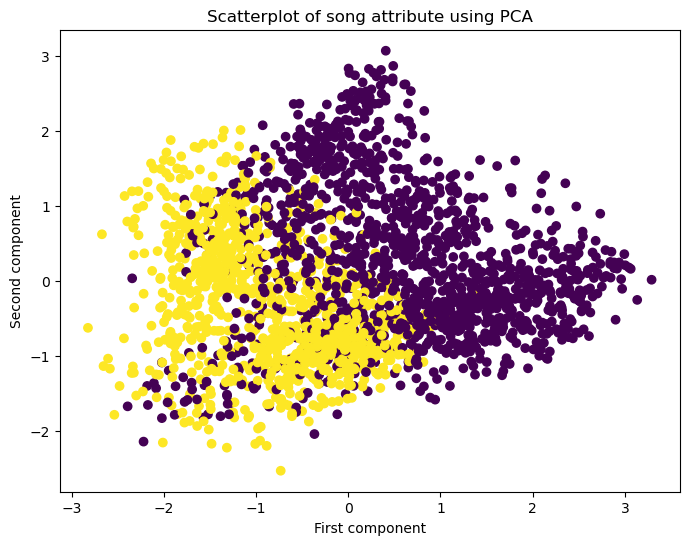

In [63]:
pca_by_class(df[numerical_attr_list], values, TARGET_CLASS)

## Dataset imbalance

In [64]:
from sklearn.model_selection import train_test_split

split_index = df.index[df['actor'] == 'actor_19'][0]

df_train = df[:split_index]
df_test = df[split_index:]

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train, df_valid = train_test_split(df_train, test_size = 0.2, random_state = 100)




In [65]:
target_class_count_t = df_train[TARGET_CLASS].sum()
target_class_count_v = df_valid[TARGET_CLASS].sum()
other_class_count_t = df_train.shape[0] - target_class_count_t
other_class_count_v = df_valid.shape[0] - target_class_count_v
eight_percent_t = int(other_class_count_t * 8 / 100)
eight_percent_v = int(other_class_count_v * 8 / 100)

# target class is 8% the size of the other one
rows_to_keep_t = np.random.choice(df_train[df_train[TARGET_CLASS] == 1].index, eight_percent_t, replace=False)
rows_to_keep_v = np.random.choice(df_valid[df_valid[TARGET_CLASS] == 1].index, eight_percent_v, replace=False)
df_train = df_train[(df_train[TARGET_CLASS] == 1 & df_train.index.isin(rows_to_keep_t)) | (df_train[TARGET_CLASS] == 0)]
df_valid = df_valid[(df_valid[TARGET_CLASS] == 1 & df_valid.index.isin(rows_to_keep_v)) | (df_valid[TARGET_CLASS] == 0)]

df_valid = df_valid.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

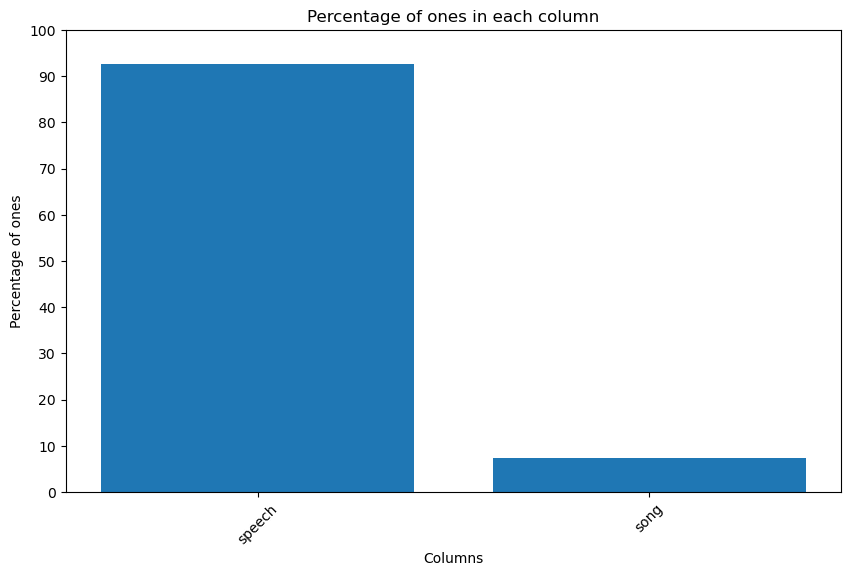

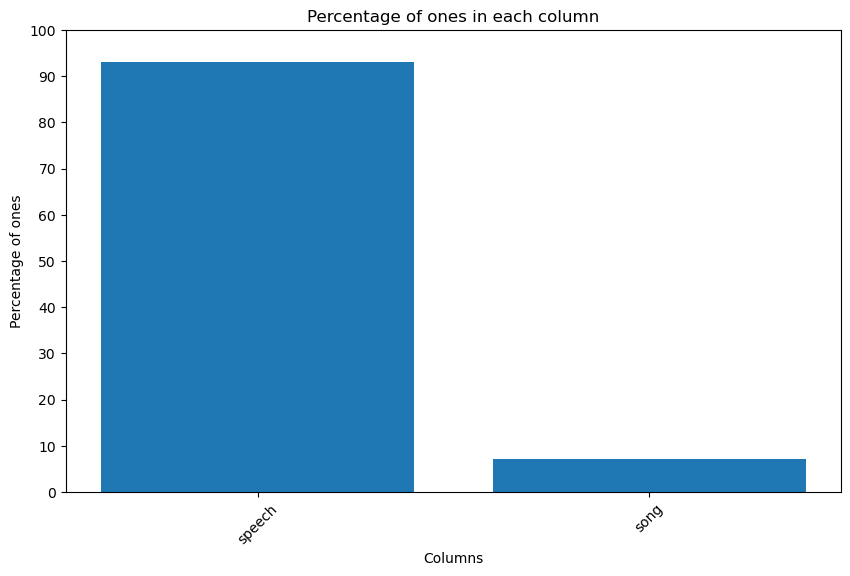

In [66]:
plot_percentage(df_train, values)
plot_percentage(df_valid, values)

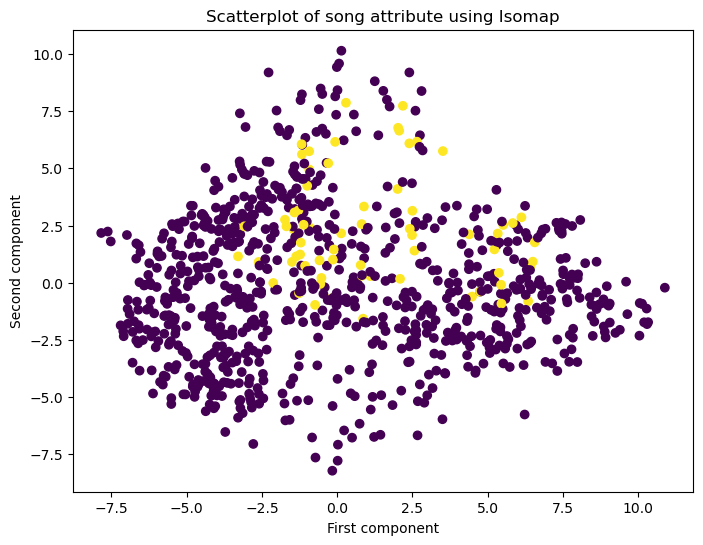

In [67]:
isomap_by_class(df_train[numerical_attr_list], values, TARGET_CLASS)

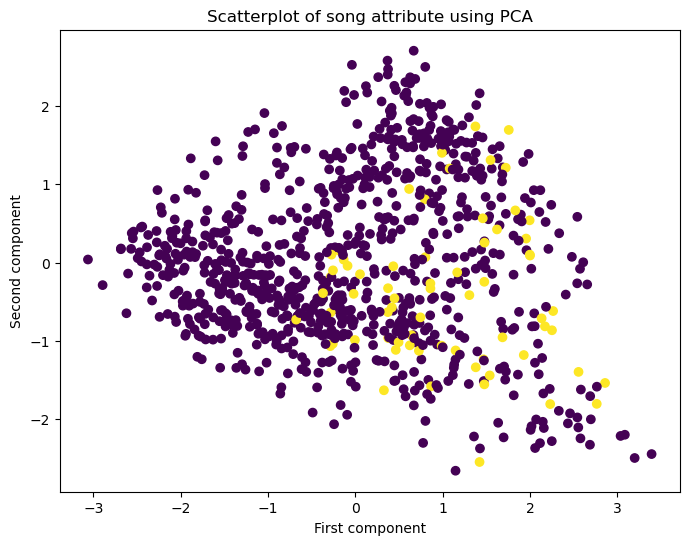

In [68]:
pca_by_class(df_train[numerical_attr_list], values, TARGET_CLASS)

# Dataset preparation

In [69]:
target_train = df_train[TARGET_CLASS]
target_valid = df_valid[TARGET_CLASS]
target_test = df_test[TARGET_CLASS]

display(df_train.shape, df_valid.shape, df_test.shape)

(914, 251)

(241, 251)

(617, 251)

In [70]:
excluded_prefixes = ['zc']
columns_to_keep = []

for column in df[numerical_attr_list].drop(values, axis=1).columns:
    if not column.startswith(tuple(excluded_prefixes)) and column != TARGET_COLUMN:
        columns_to_keep.append(column)

# selected features without target
columns_to_keep

['frame_count',
 'sum',
 'mean',
 'std',
 'min',
 'max',
 'q01',
 'q05',
 'q25',
 'q75',
 'q95',
 'q99',
 'kur',
 'skew',
 'lag1_q25',
 'lag1_q75',
 'lag1_skew',
 'mfcc_sum',
 'mfcc_mean',
 'mfcc_std',
 'mfcc_min',
 'mfcc_max',
 'mfcc_q01',
 'mfcc_q05',
 'mfcc_q25',
 'mfcc_q50',
 'mfcc_q75',
 'mfcc_q95',
 'mfcc_q99',
 'mfcc_kur',
 'mfcc_skew',
 'sc_sum',
 'sc_mean',
 'sc_std',
 'sc_min',
 'sc_max',
 'sc_q01',
 'sc_q05',
 'sc_q25',
 'sc_q50',
 'sc_q75',
 'sc_q95',
 'sc_q99',
 'sc_kur',
 'sc_skew',
 'stft_sum',
 'stft_mean',
 'stft_std',
 'stft_min',
 'stft_q01',
 'stft_q05',
 'stft_q25',
 'stft_q50',
 'stft_q75',
 'stft_kur',
 'stft_skew',
 'length_w1',
 'sum_w1',
 'std_w1',
 'q05_w1',
 'kur_w1',
 'skew_w1',
 'lag1_sum_w1',
 'lag1_max_w1',
 'lag1_q95_w1',
 'lag1_kur_w1',
 'lag1_skew_w1',
 'mfcc_sum_w1',
 'mfcc_mean_w1',
 'mfcc_std_w1',
 'mfcc_min_w1',
 'mfcc_max_w1',
 'mfcc_q05_w1',
 'mfcc_q25_w1',
 'mfcc_q50_w1',
 'mfcc_q75_w1',
 'mfcc_q95_w1',
 'mfcc_q99_w1',
 'mfcc_kur_w1',
 'mfcc_sk

In [71]:
df_train = df_train.drop(df_train.columns.difference(columns_to_keep), axis=1)
df_valid = df_valid.drop(df_valid.columns.difference(columns_to_keep), axis=1)
df_test = df_test.drop(df_test.columns.difference(columns_to_keep), axis=1)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [72]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(df_train)
X_valid = scaler.fit_transform(df_valid)
X_test = scaler.fit_transform(df_test)

y_train = target_train.to_numpy()
y_valid = target_valid.to_numpy()
y_test = target_test.to_numpy()

# Oversampling
## SMOTE

In [73]:
from collections import Counter
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)


X_res_t, y_res_t = sm.fit_resample(X_train, y_train)
X_res_v, y_res_v = sm.fit_resample(X_valid, y_valid)

print(f'Starting dataset shape: train {Counter(y_train)}   validation {Counter(y_valid)}')
print(f'Resampled dataset shape: train {Counter(y_res_t)}   validation {Counter(y_res_v)}')

Starting dataset shape: train Counter({0: 847, 1: 67})   validation Counter({0: 224, 1: 17})
Resampled dataset shape: train Counter({0: 847, 1: 847})   validation Counter({0: 224, 1: 224})


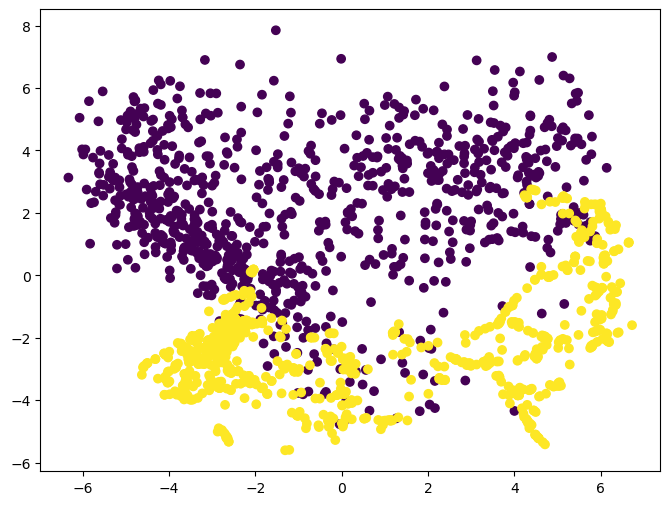

In [74]:
isomap = Isomap(n_components=2, n_neighbors=10)
embedding = isomap.fit_transform(X_res_t)

plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_res_t, cmap='viridis')
plt.show()

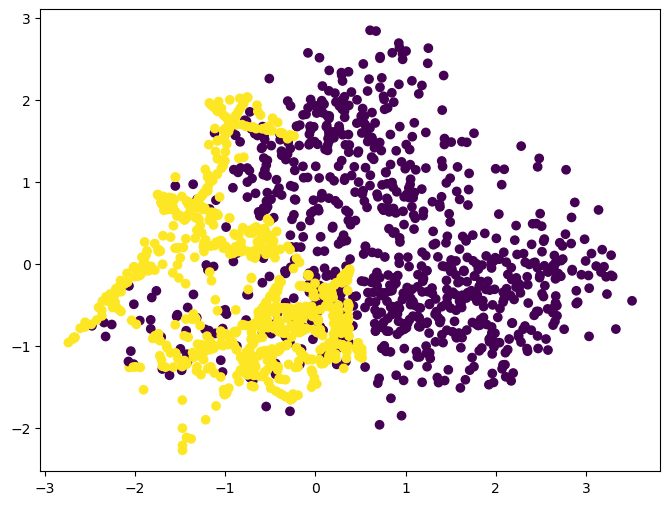

In [75]:
pca = PCA(n_components=2)
embedding = pca.fit_transform(X_res_t)

plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_res_t, cmap='viridis')
plt.show()

# Logistic Regression

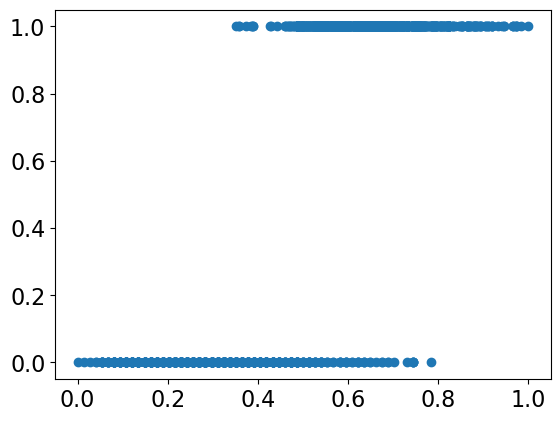

In [76]:
plt.scatter(X_res_t.T[0], y_res_t)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import optuna
from sklearn.metrics import mean_squared_error, r2_score

In [78]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['none', 'elasticnet', 'l1', 'l2'])
    C = trial.suggest_float('C', 0.001,10)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg',  'sag', 'saga'])
    

    logr = LogisticRegression(solver=solver, penalty=penalty, C=C)

    logr.fit(X_res_t, y_res_t)
    y_pred = logr.predict(X_res_v)

    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-06-12 11:40:24,702] A new study created in memory with name: no-name-1116f19c-135d-4620-bc8e-418156e1f531
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[W 2023-06-12 11:40:24,732] Trial 5 failed with parameters: {'penalty': 'elasticnet', 'C': 0.6968815557216586, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study

[I 2023-06-12 11:40:25,006] Trial 12 finished with value: 0.9977678571428571 and parameters: {'penalty': 'l2', 'C': 3.088969071919835, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9977678571428571.
[W 2023-06-12 11:40:25,012] Trial 14 failed with value None.
[W 2023-06-12 11:40:25,020] Trial 16 failed with parameters: {'penalty': 'l1', 'C': 0.2412265343902433, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\em

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-06-12 11:40:25,954] Trial 3 finished with value: 0.9933035714285714 and parameters: {'penalty': 'none', 'C': 9.355868950495468, 'solver': 'saga'}. Best is trial 11 with value: 0.9977678571428571.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[W 2023-06-12 11:40:25,973] Trial 30 failed with parameters: {'penalty': 'elasticnet', 'C': 0.1543957423565443, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-06-12 11:40:26,374] Trial 26 finished with value: 0.9866071428571429 and parameters: {'penalty': 'none', 'C': 5.714076657498826, 'solver': 'sag'}. Best is trial 11 with value: 0.9977678571428571.
[W 2023-06-12 11:40:26,376] Trial 39 failed with parameters: {'penalty': 'elasticnet', 'C': 0.2206413661224702, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linea

[W 2023-06-12 11:40:26,550] Trial 46 failed with parameters: {'penalty': 'elasticnet', 'C': 0.586113313417358, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-12 11:40:26,567] Trial 47 failed with param

[W 2023-06-12 11:40:26,664] Trial 51 failed with value None.
[W 2023-06-12 11:40:26,682] Trial 52 failed with value None.
[W 2023-06-12 11:40:26,682] Trial 54 failed with parameters: {'penalty': 'elasticnet', 'C': 0.4611807765489282, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: So

[W 2023-06-12 11:40:26,856] Trial 61 failed with parameters: {'penalty': 'elasticnet', 'C': 1.4875134873904885, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-12 11:40:26,875] Trial 5

[W 2023-06-12 11:40:27,020] Trial 66 failed with value None.
[W 2023-06-12 11:40:27,021] Trial 69 failed with parameters: {'penalty': 'elasticnet', 'C': 1.3295669460994373, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties

[W 2023-06-12 11:40:27,172] Trial 78 failed with parameters: {'penalty': 'elasticnet', 'C': 1.175032294884455, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-12 11:40:27,172] Trial 74

[W 2023-06-12 11:40:27,332] Trial 82 failed with value None.
[W 2023-06-12 11:40:27,351] Trial 83 failed with value None.
[W 2023-06-12 11:40:27,351] Trial 87 failed with parameters: {'penalty': 'elasticnet', 'C': 1.5380372792695791, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: So

[W 2023-06-12 11:40:27,500] Trial 91 failed with value None.
[W 2023-06-12 11:40:27,522] Trial 95 failed with parameters: {'penalty': 'elasticnet', 'C': 1.567185080160721, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elastic

[W 2023-06-12 11:40:27,672] Trial 99 failed with value None.
[W 2023-06-12 11:40:27,681] Trial 101 failed with value None.
[W 2023-06-12 11:40:27,692] Trial 104 failed with parameters: {'penalty': 'elasticnet', 'C': 1.35210875809181, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: So

[W 2023-06-12 11:40:27,821] Trial 108 failed with value None.
[W 2023-06-12 11:40:27,855] Trial 112 failed with parameters: {'penalty': 'elasticnet', 'C': 1.4345538305289978, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elas

[W 2023-06-12 11:40:27,990] Trial 116 failed with value None.
[W 2023-06-12 11:40:27,992] Trial 115 failed with value None.
[W 2023-06-12 11:40:28,010] Trial 121 failed with parameters: {'penalty': 'elasticnet', 'C': 1.3448503520400608, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError:

[W 2023-06-12 11:40:28,121] Trial 124 failed with value None.
[W 2023-06-12 11:40:28,140] Trial 128 failed with parameters: {'penalty': 'elasticnet', 'C': 1.280138695288854, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penaltie

[W 2023-06-12 11:40:28,291] Trial 136 failed with parameters: {'penalty': 'elasticnet', 'C': 1.3854738964371105, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-12 11:40:28,291] Trial 

[W 2023-06-12 11:40:28,448] Trial 144 failed with parameters: {'penalty': 'elasticnet', 'C': 1.3834589734608664, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-12 11:40:28,464] Trial 

In [79]:
best_params = study.best_params

logr = LogisticRegression(**best_params)
logr.fit(X_res_t.T[0].reshape(-1,1), y_res_t)

y_pred_test = logr.predict(X_test.T[0].reshape(-1,1))


from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l2', 'C': 1.380678404120397, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       355
           1       0.92      0.88      0.90       262

    accuracy                           0.92       617
   macro avg       0.92      0.91      0.91       617
weighted avg       0.92      0.92      0.92       617

Accuracy 0.9157212317666127
F1-score [0.92777778 0.89883268]


choose liblinear solver beacause for small datasets is a good choice. 
The key difference between these l1(ridege) and l2(lasso) is that Lasso shrinks the less 
important feature’s coefficient to zero thus, removing some feature altogether. 
So, this works well for feature selection in case we have a huge number of features.

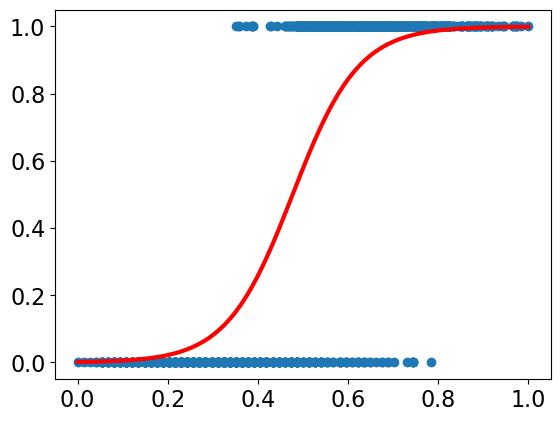

In [80]:
from scipy.special import expit

loss = expit(sorted(X_test.T[0].reshape(-1,1)) *logr.coef_.T[0] + logr.intercept_).ravel()
plt.plot(sorted(X_test.T[0].reshape(-1,1)), loss, color='red', linewidth=3)
plt.scatter(X_res_t.T[0].reshape(-1,1), y_res_t)
#plt.xlabel(selected_columns[0], fontsize=16)
#plt.ylabel('Occupancy', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

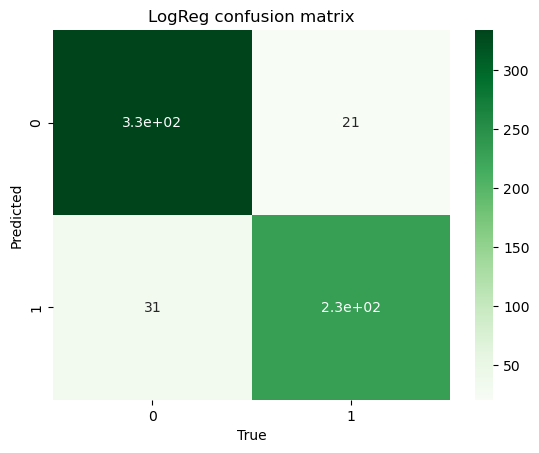

In [81]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LogReg confusion matrix')
plt.show()

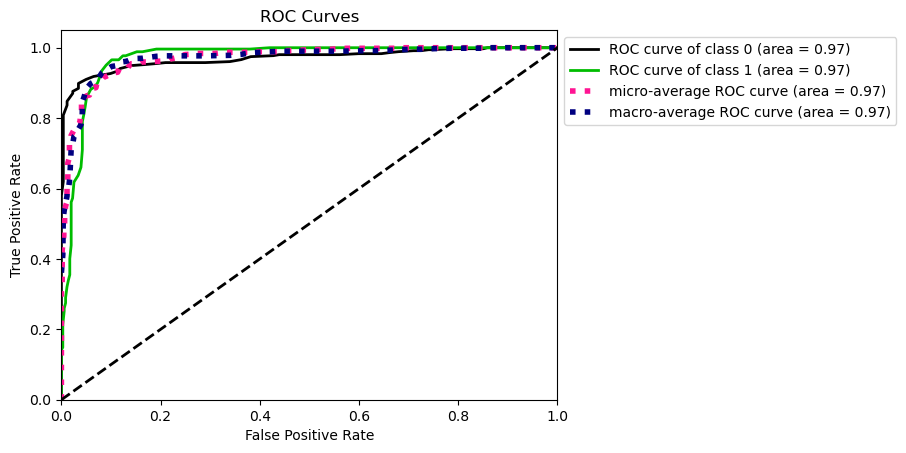

0.9694925276851951


In [82]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc

y_test_pred_proba = logr.predict_proba(X_test.T[0].reshape(-1,1))
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

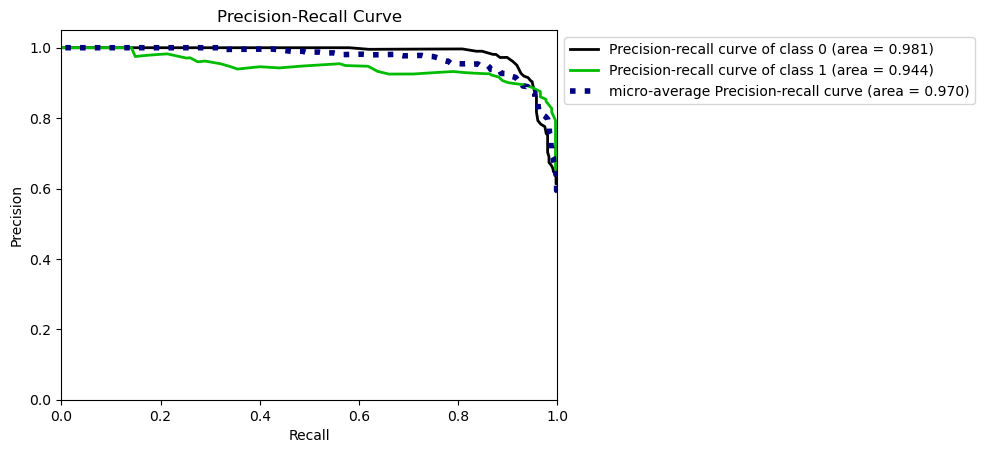

In [83]:
from scikitplot.metrics import plot_precision_recall

plot_precision_recall(y_test, logr.predict_proba(X_test.T[0].reshape(-1,1)))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# Suppport Vector Machine

In [84]:
pca = PCA(n_components=2)
pca.fit(X_res_t)
X_pca = pca.transform(X_res_t)

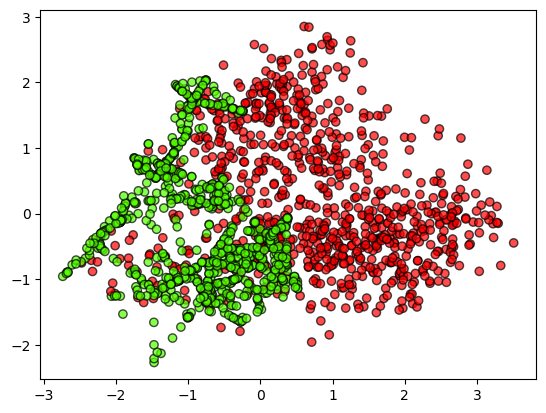

In [85]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

## Linear SVM

In [86]:
from sklearn.svm import LinearSVC

In [87]:
# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.01,100)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    

    lin_svc = LinearSVC(loss=loss, penalty=penalty, C=C)

    lin_svc.fit(X_res_t, y_res_t)
    y_pred = lin_svc.predict(X_res_v)

    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-06-12 11:40:30,023] A new study created in memory with name: no-name-09c331d4-075a-44dd-8d12-ee61dad1d48c
[W 2023-06-12 11:40:30,042] Trial 0 failed with parameters: {'penalty': 'l1', 'C': 78.91645991144345, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    so

[W 2023-06-12 11:40:30,148] Trial 12 failed with value None.
[W 2023-06-12 11:40:30,158] Trial 14 failed with parameters: {'penalty': 'l1', 'C': 59.26140671693832, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = 

[I 2023-06-12 11:40:30,383] Trial 9 finished with value: 0.9799107142857143 and parameters: {'penalty': 'l2', 'C': 97.17417716689643, 'loss': 'hinge'}. Best is trial 1 with value: 0.9799107142857143.
[I 2023-06-12 11:40:30,383] Trial 13 finished with value: 0.9799107142857143 and parameters: {'penalty': 'l2', 'C': 50.660294708033554, 'loss': 'hinge'}. Best is trial 1 with value: 0.9799107142857143.
[W 2023-06-12 11:40:30,383] Trial 23 failed with parameters: {'penalty': 'l1', 'C': 10.487165098683173, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[W 2023-06-12 11:40:30,637] Trial 34 failed with parameters: {'penalty': 'l1', 'C': 32.134404368185855, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C

[W 2023-06-12 11:40:30,772] Trial 36 failed with value None.
[I 2023-06-12 11:40:30,772] Trial 32 finished with value: 0.9799107142857143 and parameters: {'penalty': 'l2', 'C': 66.92675346794029, 'loss': 'hinge'}. Best is trial 1 with value: 0.9799107142857143.
[W 2023-06-12 11:40:30,781] Trial 40 failed with parameters: {'penalty': 'l1', 'C': 33.22824707317493, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", l

[W 2023-06-12 11:40:30,930] Trial 42 failed with value None.
[W 2023-06-12 11:40:30,932] Trial 46 failed with parameters: {'penalty': 'l1', 'C': 43.111671240164064, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type =

[W 2023-06-12 11:40:31,066] Trial 52 failed with parameters: {'penalty': 'l1', 'C': 38.36549699605048, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)


[W 2023-06-12 11:40:31,170] Trial 58 failed with parameters: {'penalty': 'l1', 'C': 37.77019832344877, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)


[W 2023-06-12 11:40:31,294] Trial 64 failed with parameters: {'penalty': 'l1', 'C': 39.31281370520344, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)


[W 2023-06-12 11:40:31,422] Trial 70 failed with parameters: {'penalty': 'l1', 'C': 48.1470325259119, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
 

[W 2023-06-12 11:40:31,532] Trial 72 failed with value None.
[W 2023-06-12 11:40:31,532] Trial 76 failed with parameters: {'penalty': 'l1', 'C': 85.55970397033438, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = 

[W 2023-06-12 11:40:31,662] Trial 77 failed with value None.
[W 2023-06-12 11:40:31,671] Trial 82 failed with parameters: {'penalty': 'l1', 'C': 42.60764596351009, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = 

[W 2023-06-12 11:40:31,828] Trial 87 failed with parameters: {'penalty': 'l1', 'C': 39.38311858847538, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)


[W 2023-06-12 11:40:31,926] Trial 90 failed with value None.
[W 2023-06-12 11:40:31,942] Trial 91 failed with value None.
[W 2023-06-12 11:40:31,949] Trial 94 failed with parameters: {'penalty': 'l1', 'C': 39.44968578967918, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\s

[W 2023-06-12 11:40:32,095] Trial 95 failed with value None.
[W 2023-06-12 11:40:32,101] Trial 96 failed with value None.
[W 2023-06-12 11:40:32,114] Trial 100 failed with parameters: {'penalty': 'l1', 'C': 37.419099887516026, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn

[W 2023-06-12 11:40:32,252] Trial 102 failed with value None.
[W 2023-06-12 11:40:32,252] Trial 106 failed with parameters: {'penalty': 'l1', 'C': 42.022649536463376, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type

[W 2023-06-12 11:40:32,370] Trial 112 failed with parameters: {'penalty': 'l1', 'C': 41.60345929388148, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)

[W 2023-06-12 11:40:32,483] Trial 114 failed with value None.
[W 2023-06-12 11:40:32,483] Trial 118 failed with parameters: {'penalty': 'l1', 'C': 41.53468324936056, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type 

[W 2023-06-12 11:40:32,611] Trial 120 failed with value None.
[W 2023-06-12 11:40:32,611] Trial 124 failed with parameters: {'penalty': 'l1', 'C': 40.46573198975403, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type 

[W 2023-06-12 11:40:32,740] Trial 126 failed with value None.
[W 2023-06-12 11:40:32,771] Trial 127 failed with value None.
[W 2023-06-12 11:40:32,772] Trial 130 failed with parameters: {'penalty': 'l1', 'C': 39.94694995881956, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklear

[W 2023-06-12 11:40:32,875] Trial 132 failed with value None.
[W 2023-06-12 11:40:32,881] Trial 136 failed with parameters: {'penalty': 'l1', 'C': 38.52560515808183, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type 

[W 2023-06-12 11:40:33,002] Trial 138 failed with value None.
[W 2023-06-12 11:40:33,006] Trial 142 failed with parameters: {'penalty': 'l1', 'C': 34.90767788818242, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type 

[W 2023-06-12 11:40:33,122] Trial 144 failed with value None.
[W 2023-06-12 11:40:33,122] Trial 148 failed with parameters: {'penalty': 'l1', 'C': 42.44600863144058, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type 

In [88]:
best_params = study.best_params

lin_svc = LinearSVC(**best_params)
lin_svc.fit(X_res_t, y_res_t)

y_pred_test = lin_svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l2', 'C': 61.27995388698502, 'loss': 'squared_hinge'}
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       355
           1       0.98      0.89      0.93       262

    accuracy                           0.94       617
   macro avg       0.95      0.94      0.94       617
weighted avg       0.95      0.94      0.94       617

Accuracy 0.9448946515397083
F1-score [0.95380435 0.93172691]


C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


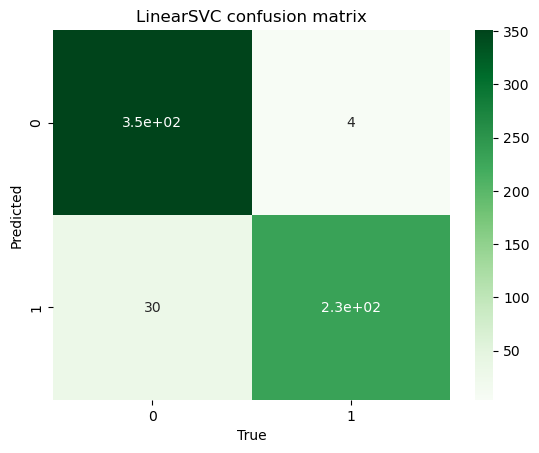

In [89]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LinearSVC confusion matrix')
plt.show()

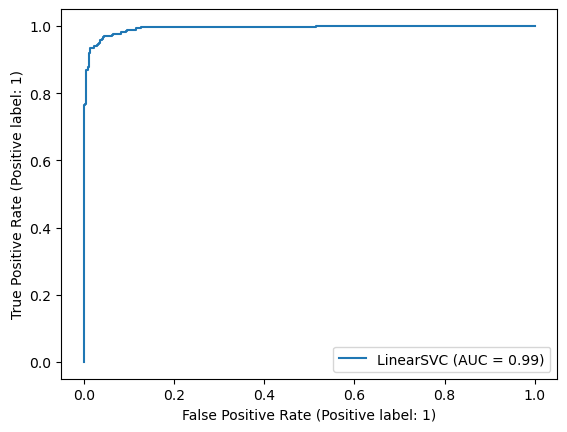

In [90]:
from sklearn.metrics import RocCurveDisplay

linear_svc_disp = RocCurveDisplay.from_estimator(lin_svc, X_test, y_test)

In [91]:
decision_function = lin_svc.decision_function(X_res_t)
support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
support_vectors = X_res_t[support_vector_indices]

In [92]:
support_vectors_pca = pca.transform(support_vectors)

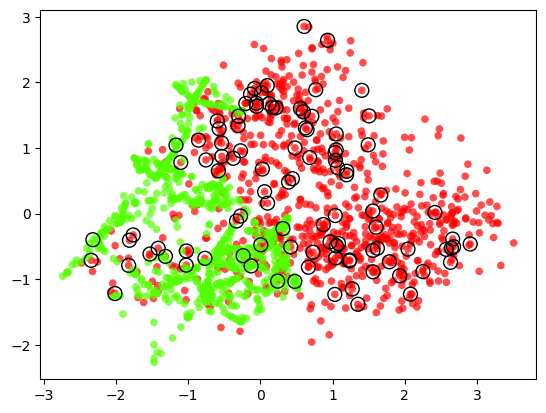

In [93]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


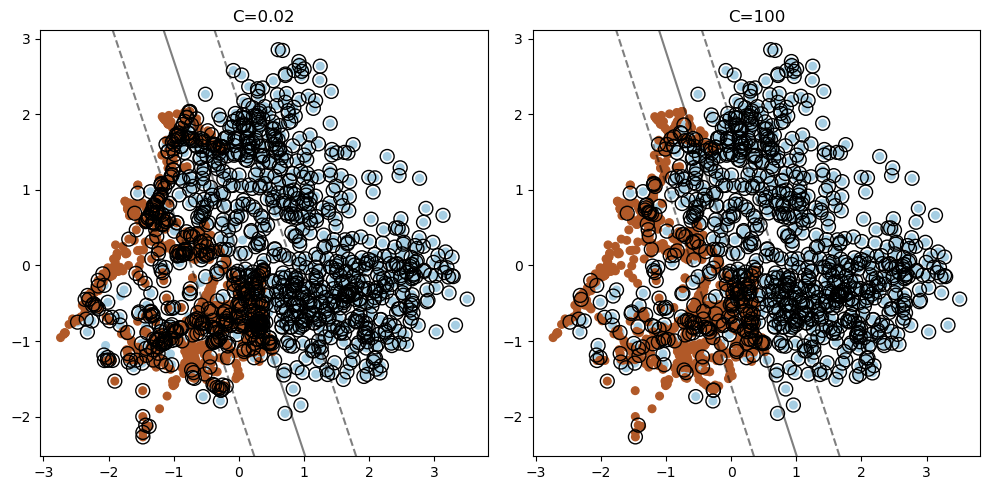

In [94]:
plt.figure(figsize=(10, 5))
for i, C in enumerate([0.02, 100]):
    # "hinge" is the standard SVM loss
    clf = LinearSVC(C=C, loss="squared_hinge", penalty='l2', random_state=42).fit(X_res_t, y_res_t)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X_res_t)
#     we can also calculate the decision function manually
#     decision_function = np.dot(X_pca, clf.coef_[0]) + clf.intercept_[0]
    support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
    support_vectors = X_res_t[support_vector_indices]
    support_vectors_pca = pca.transform(support_vectors)

    plt.subplot(1, 2, i + 1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X_pca, y_res_t)
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
    plt.title("C=" + str(C))
    #plt.scatter(clf.coef_[:, 0] + clf.intercept_, clf.coef_[:, 1] + clf.intercept_)
plt.tight_layout()
plt.show()

The goal for SVM is find hyperplane that maximizes the margin, furthermore C is the inverse of regularization strength therefore smaller value of C correspond a stronger regularization namely greater margin

## Nonlinear SVM

In [95]:
from sklearn.svm import SVC

In [96]:
# objective function to be minimized
def objective_fun(trial):

    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    C = trial.suggest_float('C', 0.01,100)
    gamma = trial.suggest_float('gamma', 0.001, 1)
    

    lin_svc = SVC(kernel=kernel, gamma=gamma, C=C)

    lin_svc.fit(X_res_t, y_res_t)
    y_pred = lin_svc.predict(X_res_v)

    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-06-12 11:40:35,140] A new study created in memory with name: no-name-75fb7efb-150d-480c-98e6-d5ca9258b76b
[I 2023-06-12 11:40:35,385] Trial 4 finished with value: 0.9866071428571429 and parameters: {'kernel': 'poly', 'C': 54.73677203493665, 'gamma': 0.5763828011680843}. Best is trial 4 with value: 0.9866071428571429.
[I 2023-06-12 11:40:35,396] Trial 5 finished with value: 0.9866071428571429 and parameters: {'kernel': 'poly', 'C': 35.27168292129176, 'gamma': 0.5029953255696396}. Best is trial 4 with value: 0.9866071428571429.
[I 2023-06-12 11:40:35,403] Trial 6 finished with value: 0.9866071428571429 and parameters: {'kernel': 'poly', 'C': 47.601338092420974, 'gamma': 0.156252138597852}. Best is trial 4 with value: 0.9866071428571429.
[I 2023-06-12 11:40:35,430] Trial 7 finished with value: 0.9464285714285714 and parameters: {'kernel': 'rbf', 'C': 64.17437740525926, 'gamma': 0.18688209575167763}. Best is trial 4 with value: 0.9866071428571429.
[I 2023-06-12 11:40:35,464] Trial 

[I 2023-06-12 11:40:37,383] Trial 39 finished with value: 0.9866071428571429 and parameters: {'kernel': 'poly', 'C': 76.22153990906041, 'gamma': 0.7498855459787168}. Best is trial 33 with value: 0.9977678571428571.
[I 2023-06-12 11:40:37,421] Trial 42 finished with value: 0.9866071428571429 and parameters: {'kernel': 'poly', 'C': 30.925876265582612, 'gamma': 0.019070985110279062}. Best is trial 33 with value: 0.9977678571428571.
[I 2023-06-12 11:40:37,421] Trial 44 finished with value: 0.9709821428571429 and parameters: {'kernel': 'rbf', 'C': 9.636341038753208, 'gamma': 0.10562700925123034}. Best is trial 33 with value: 0.9977678571428571.
[I 2023-06-12 11:40:37,482] Trial 43 finished with value: 0.9955357142857143 and parameters: {'kernel': 'rbf', 'C': 30.044206049838692, 'gamma': 0.0024064008908987002}. Best is trial 33 with value: 0.9977678571428571.
[I 2023-06-12 11:40:37,597] Trial 41 finished with value: 0.9910714285714286 and parameters: {'kernel': 'poly', 'C': 47.13752692829315

[I 2023-06-12 11:40:39,250] Trial 81 finished with value: 0.9977678571428571 and parameters: {'kernel': 'poly', 'C': 57.07742002013665, 'gamma': 0.00593578711755062}. Best is trial 33 with value: 0.9977678571428571.
[I 2023-06-12 11:40:39,312] Trial 79 finished with value: 0.9888392857142857 and parameters: {'kernel': 'poly', 'C': 53.905749450532156, 'gamma': 0.0036075067099609285}. Best is trial 33 with value: 0.9977678571428571.
[I 2023-06-12 11:40:39,343] Trial 77 finished with value: 0.9910714285714286 and parameters: {'kernel': 'poly', 'C': 28.720416525688147, 'gamma': 0.0034692813298981043}. Best is trial 33 with value: 0.9977678571428571.
[I 2023-06-12 11:40:39,377] Trial 78 finished with value: 0.9910714285714286 and parameters: {'kernel': 'poly', 'C': 55.43943369905149, 'gamma': 0.002532795317386637}. Best is trial 33 with value: 0.9977678571428571.
[I 2023-06-12 11:40:39,432] Trial 82 finished with value: 0.9977678571428571 and parameters: {'kernel': 'poly', 'C': 31.084141243

[I 2023-06-12 11:40:40,802] Trial 115 finished with value: 0.96875 and parameters: {'kernel': 'rbf', 'C': 53.18571673294908, 'gamma': 0.1161329016461411}. Best is trial 33 with value: 0.9977678571428571.
[I 2023-06-12 11:40:40,831] Trial 118 finished with value: 0.9799107142857143 and parameters: {'kernel': 'rbf', 'C': 62.76416356638937, 'gamma': 0.05675366159504133}. Best is trial 33 with value: 0.9977678571428571.
[I 2023-06-12 11:40:40,832] Trial 113 finished with value: 0.9977678571428571 and parameters: {'kernel': 'poly', 'C': 65.67016554608888, 'gamma': 0.004888775445949317}. Best is trial 33 with value: 0.9977678571428571.
[I 2023-06-12 11:40:41,033] Trial 119 finished with value: 0.9776785714285714 and parameters: {'kernel': 'rbf', 'C': 64.25507111359806, 'gamma': 0.059329738977826764}. Best is trial 33 with value: 0.9977678571428571.
[I 2023-06-12 11:40:41,110] Trial 114 finished with value: 0.9799107142857143 and parameters: {'kernel': 'poly', 'C': 38.8534851854409, 'gamma': 

In [97]:
best_params = study.best_params

svc = SVC(**best_params)
svc.fit(X_res_t, y_res_t)

y_pred_test = svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'kernel': 'poly', 'C': 35.14014510559884, 'gamma': 0.009304139736305256}
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       355
           1       0.99      0.88      0.93       262

    accuracy                           0.94       617
   macro avg       0.95      0.94      0.94       617
weighted avg       0.95      0.94      0.94       617

Accuracy 0.9448946515397083
F1-score [0.95405405 0.93117409]


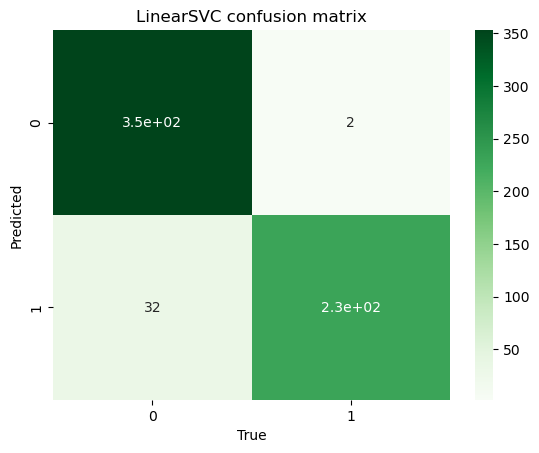

In [98]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LinearSVC confusion matrix')
plt.show()

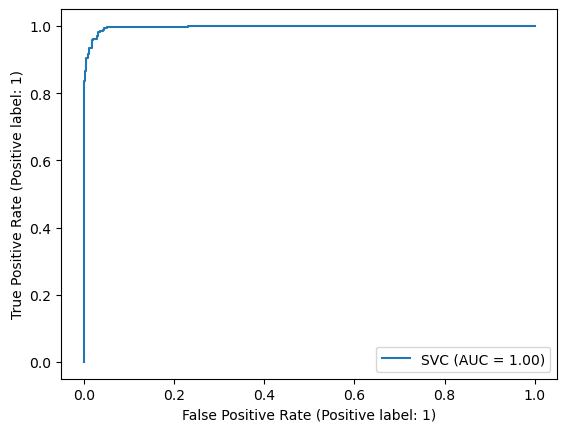

In [99]:
svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test)

In [100]:
support_vectors_pca = pca.transform(svc.support_vectors_)

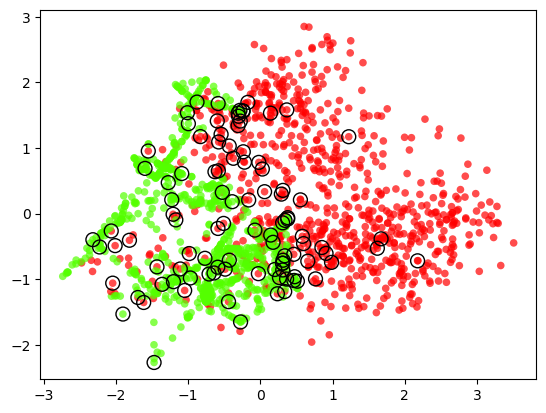

In [101]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, 
            cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [102]:
decision_function = svc.decision_function(X_res_t)
support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
support_vectors = X_res_t[support_vector_indices]

In [103]:
support_vectors_pca = pca.transform(support_vectors)

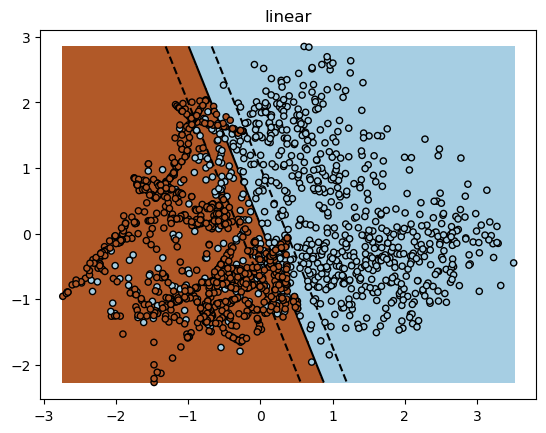

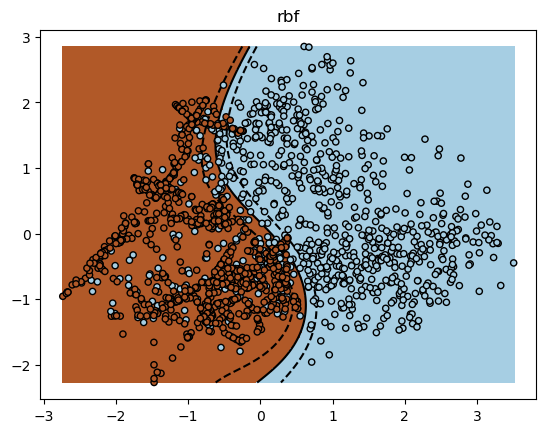

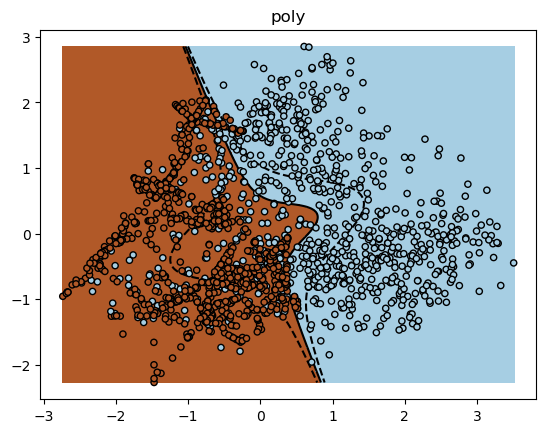

In [104]:
for kernel in ('linear', 'rbf', 'poly'):
    clf = SVC(kernel=kernel, gamma=0.1, C=26)
    clf.fit(X_res_t, y_res_t)

    plt.figure()
    plt.clf()
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, zorder=10, cmap=plt.cm.Paired,
                edgecolor='k', s=20)

    # Circle out the test data
#     plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], s=80, facecolors='none',
#                 zorder=10, edgecolor='k')

    plt.axis('tight')
    x_min = X_pca[:, 0].min()
    x_max = X_pca[:, 0].max()
    y_min = X_pca[:, 1].min()
    y_max = X_pca[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    clf.fit(X_pca, y_res_t)
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

    plt.title(kernel)
plt.show()

Show the different boundary for different kernel:
-Linear: just see previuos section
-Radial: Basis Function:The gamma parameters can be seen as the inverse of the radius of influence of   samples selected
-poly : the polynomial kernel looks not only at the given features of input samples to determine their similarity, but also combinations of these

# Neural Networks

In [105]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense

In [106]:
from scikeras.wrappers import KerasClassifier

In [107]:
from sklearn.model_selection import RandomizedSearchCV

In [108]:
#  build the model for neural networks
def build_model(meta, hidden_layer_sizes, activation, optimizer):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation=activation))
    model.add(keras.layers.Dense(n_classes_, activation="softmax"))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [109]:
#Use Sklearn wrapper
clf = KerasClassifier(
    model = build_model,
    verbose = False
)

In [110]:
# objective function to be minimized
import random
import optuna
def objective_fun(trial):
    
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes',[(100, 100, 100), (50, 50, 50), (10, 10, 10), 
                                  (100, 50, 10), (10, 10, 10), (10, 10)])
#     learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    net = KerasClassifier(model=build_model(par, hidden_layer_sizes, activation, optimizer ))
    net.fit(X_res_t, y_res_t, epochs=50)
    y_pred = net.predict(X_res_v).astype(int)
#     print(y_pred.shape, y_res_v.shape)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-06-12 11:41:14,171] A new study created in memory with name: no-name-5aaf9bd5-c5fa-4695-951c-295c08c930bf
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 50, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
53/53 [==============================] - 11s 37ms/step - loss: 0.7529 - accuracy: 0.5000
Epoch 2/50
53/53 [==============================] - 1s 27ms/step - loss: 0.5099 - accuracy: 0.9410
Epoch 3/50
53/53 [==============================] - 12s 18ms/step - loss: 0.5421 - accuracy: 0.8388
Epoch 4/50
53/53 [==============================] - 1s 23ms/step - loss: 0.1914 - accuracy: 0.9669
Epoch 3/50
53/53 [==============================] - 14s 17ms/step - loss: 0.2695 - accuracy: 0.9091
Epoch 5/50
53/53 [==============================] - 1s 16ms/step - loss: 0.2418 - accuracy: 0.9675
Epoch 6/50
53/53 [==============================] - 1s 16ms/step - loss: 0.1396 - accuracy: 0.9705
Epoch 3/50
53/53 [==============================] - 1s 16ms/step - loss: 0.6941 - accuracy: 0.4793
Epoch 3/50
53/53 [==============================] - 1s 14ms/step - loss: 0.3957 - accuracy: 0.9380
Epoch 4/50
Epoch 3/50
29/53 [

53/53 [==============================] - 1s 15ms/step - loss: 0.0473 - accuracy: 0.9858
Epoch 10/50
 1/53 [..............................] - ETA: 0s - loss: 0.6941 - accuracy: 0.3125Epoch 7/50
Epoch 8/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0635 - accuracy: 0.9847
Epoch 7/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0353 - accuracy: 0.9894
Epoch 9/50
49/53 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.4841Epoch 14/50
Epoch 11/50
53/53 [==============================] - 1s 15ms/step - loss: 0.6936 - accuracy: 0.4888
Epoch 14/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0419 - accuracy: 0.9900
Epoch 11/50
25/53 [=============>................] - ETA: 0s - loss: 0.0423 - accuracy: 0.9925Epoch 13/50
Epoch 12/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0379 - accuracy: 0.9911


53/53 [==============================] - 1s 14ms/step - loss: 0.0671 - accuracy: 0.9823
Epoch 17/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0285 - accuracy: 0.9929
Epoch 19/50
Epoch 15/50
53/53 [==============================] - 1s 14ms/step - loss: 0.6934 - accuracy: 0.4858
Epoch 17/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0658 - accuracy: 0.9799
Epoch 17/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0262 - accuracy: 0.9941
Epoch 21/50
Epoch 17/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0164 - accuracy: 0.9941
Epoch 20/50
51/53 [===========================>..] - ETA: 0s - loss: 0.0593 - accuracy: 0.9810Epoch 19/50


53/53 [==============================] - 1s 15ms/step - loss: 0.0607 - accuracy: 0.9811
Epoch 18/50
30/53 [===============>..............] - ETA: 0s - loss: 0.0431 - accuracy: 0.9875Epoch 22/50
Epoch 20/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0560 - accuracy: 0.9841
Epoch 24/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0052 - accuracy: 0.9988
Epoch 21/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0121 - accuracy: 0.9970
Epoch 25/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0020 - accuracy: 0.9994
Epoch 22/50
49/53 [==========================>...] - ETA: 0s - loss: 9.5713e-04 - accuracy: 1.0000Epoch 25/50
Epoch 23/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0507 - accuracy: 0.9847
Epoch 27/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0162 - accuracy: 0.9965


53/53 [==============================] - 1s 14ms/step - loss: 0.0144 - accuracy: 0.9965
Epoch 25/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0487 - accuracy: 0.9852
Epoch 29/50
53/53 [==============================] - 1s 16ms/step - loss: 0.6930 - accuracy: 0.5148
Epoch 27/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0131 - accuracy: 0.9976
Epoch 29/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0275 - accuracy: 0.9923
Epoch 33/50
53/53 [==============================] - 1s 13ms/step - loss: 0.0059 - accuracy: 0.9988


46/53 [=========================>....] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000Epoch 34/50
Epoch 34/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0053 - accuracy: 0.9988
Epoch 33/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0414 - accuracy: 0.9864
Epoch 32/50
27/53 [==============>...............] - ETA: 0s - loss: 0.0139 - accuracy: 0.9977Epoch 35/50
Epoch 35/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0025 - accuracy: 0.9988
Epoch 36/50
11/53 [=====>........................] - ETA: 0s - loss: 0.0166 - accuracy: 0.9915Epoch 35/50
Epoch 36/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0379 - accuracy: 0.9888
Epoch 39/50
53/53 [==============================] - 1s 15ms/step - loss: 7.3600e-04 - accuracy: 1.0000


53/53 [==============================] - 1s 17ms/step - loss: 0.0046 - accuracy: 0.9982
Epoch 42/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0221 - accuracy: 0.9941
Epoch 43/50
 9/53 [====>.........................] - ETA: 0s - loss: 0.6921 - accuracy: 0.5174Epoch 44/50
Epoch 42/50
21/53 [==========>...................] - ETA: 0s - loss: 0.0051 - accuracy: 0.9970Epoch 43/50
Epoch 41/50
41/53 [======================>.......] - ETA: 0s - loss: 0.0331 - accuracy: 0.9901Epoch 44/50


53/53 [==============================] - 1s 16ms/step - loss: 0.0194 - accuracy: 0.9959
Epoch 46/50
Epoch 44/50
53/53 [==============================] - 1s 18ms/step - loss: 3.9272e-04 - accuracy: 1.0000
Epoch 45/50
49/53 [==========================>...] - ETA: 0s - loss: 0.0204 - accuracy: 0.9943Epoch 47/50
Epoch 44/50
53/53 [==============================] - 1s 15ms/step - loss: 3.6049e-04 - accuracy: 1.0000
Epoch 48/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 45/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0044 - accuracy: 0.9994
Epoch 45/50
30/53 [===============>..............] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000Epoch 49/50
Epoch 46/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0141 - accuracy: 0.9970
Epoch 49/50
53/53 [==============================] - 1s 14ms/step - loss: 3.3652e-04 - accuracy: 1.0000
Epoch 47/50
53/53 [==============================] - 1s 14ms/step - loss: 0.

14/14 [==============================] - 1s 16ms/stepss: 5.1942e-04 - accuracy: 1.00
Epoch 49/50
53/53 [==============================] - 1s 21ms/step - loss: 0.0033 - accuracy: 0.9994
Epoch 48/50
18/53 [=========>....................] - ETA: 0s - loss: 6.4111e-04 - accuracy: 1.0000

[I 2023-06-12 11:42:08,907] Trial 5 finished with value: 0.5 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 5 with value: 0.5.
[I 2023-06-12 11:42:08,924] Trial 6 finished with value: 0.9977678571428571 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site

21/53 [==========>...................] - ETA: 0s - loss: 0.0019 - accuracy: 1.000000

[I 2023-06-12 11:42:09,371] Trial 3 finished with value: 0.9933035714285714 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


29/53 [===============>..............] - ETA: 0s - loss: 0.0020 - accuracy: 1.000000

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

53/53 [==============================] - 2s 31ms/step - loss: 0.0131 - accuracy: 0.9976
Epoch 50/50
 1/53 [..............................] - ETA: 1s - loss: 0.0053 - accuracy: 1.0000Epoch 49/50


[I 2023-06-12 11:42:10,492] Trial 1 finished with value: 0.984375 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


 4/53 [=>............................] - ETA: 2s - loss: 0.0027 - accuracy: 1.000000

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 1/50
39/53 [=====================>........] - ETA: 0s - loss: 0.0103 - accuracy: 0.998400

[I 2023-06-12 11:42:11,806] Trial 0 finished with value: 0.984375 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


52/53 [============================>.] - ETA: 0s - loss: 2.7080e-04 - accuracy: 1.0000

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

53/53 [==============================] - 2s 39ms/step - loss: 0.0119 - accuracy: 0.9982
Epoch 50/50
37/53 [===================>..........] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

[I 2023-06-12 11:42:14,361] Trial 2 finished with value: 0.984375 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


46/53 [=========================>....] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

53/53 [==============================] - 2s 41ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 1/50
14/14 [==============================] - 1s 17ms/step
Epoch 1/50
 7/53 [==>...........................] - ETA: 1s - loss: 0.6981 - accuracy: 0.5312

[I 2023-06-12 11:42:16,153] Trial 4 finished with value: 0.9888392857142857 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


15/53 [=======>......................] - ETA: 1s - loss: 0.6801 - accuracy: 0.5854

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

53/53 [==============================] - 8s 38ms/step - loss: 0.6478 - accuracy: 0.6446
Epoch 2/50
53/53 [==============================] - 10s 37ms/step - loss: 0.7155 - accuracy: 0.4782
Epoch 2/50
53/53 [==============================] - 1s 23ms/step - loss: 0.6788 - accuracy: 0.5496
Epoch 5/50
Epoch 3/50
53/53 [==============================] - 1s 18ms/step - loss: 0.1319 - accuracy: 0.9728
Epoch 7/50
11/53 [=====>........................] - ETA: 0s - loss: 0.7017 - accuracy: 0.5114Epoch 5/50
Epoch 5/50
53/53 [==============================] - 1s 14ms/step - loss: 0.1174 - accuracy: 0.9723
Epoch 8/50
53/53 [==============================] - 1s 15ms/step - loss: 0.5149 - accuracy: 0.9610
Epoch 7/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0984 - accuracy: 0.9776


53/53 [==============================] - 1s 16ms/step - loss: 0.1615 - accuracy: 0.9723
Epoch 12/50
33/53 [=================>............] - ETA: 0s - loss: 0.0745 - accuracy: 0.9839Epoch 10/50
Epoch 8/50
53/53 [==============================] - 1s 15ms/step - loss: 0.1328 - accuracy: 0.9711
Epoch 13/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0539 - accuracy: 0.9811
Epoch 10/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0222 - accuracy: 0.9935
Epoch 9/50
Epoch 11/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0457 - accuracy: 0.9835
Epoch 12/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0706 - accuracy: 0.9793


44/53 [=======================>......] - ETA: 0s - loss: 0.0697 - accuracy: 0.9815Epoch 13/50
Epoch 10/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0680 - accuracy: 0.9811
Epoch 14/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0107 - accuracy: 0.9970
Epoch 15/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0734 - accuracy: 0.9817
Epoch 20/50
15/53 [=======>......................] - ETA: 0s - loss: 0.0549 - accuracy: 0.9854Epoch 17/50
Epoch 15/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0565 - accuracy: 0.9835


25/53 [=============>................] - ETA: 0s - loss: 0.0077 - accuracy: 0.9987Epoch 25/50
Epoch 20/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0093 - accuracy: 0.9982
Epoch 21/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0428 - accuracy: 0.9888
Epoch 18/50
Epoch 22/50
53/53 [==============================] - 1s 13ms/step - loss: 0.0400 - accuracy: 0.9917
Epoch 25/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0519 - accuracy: 0.9858
Epoch 27/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - accuracy: 0.9988
Epoch 23/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0519 - accuracy: 0.9823
Epoch 23/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0506 - accuracy: 0.9852
Epoch 28/50
Epoch 23/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0202 - accuracy: 0.9953
Epoch 20/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0475 -

28/53 [==============>...............] - ETA: 0s - loss: 0.0317 - accuracy: 0.9944Epoch 24/50
Epoch 22/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0444 - accuracy: 0.9858
Epoch 26/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0316 - accuracy: 0.9923
Epoch 27/50
22/53 [===========>..................] - ETA: 0s - loss: 0.0225 - accuracy: 0.9957Epoch 23/50
Epoch 25/50
42/53 [======================>.......] - ETA: 0s - loss: 0.0239 - accuracy: 0.9918Epoch 28/50
Epoch 28/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0404 - accuracy: 0.9876
Epoch 30/50
19/53 [=========>....................] - ETA: 0s - loss: 0.0468 - accuracy: 0.9803Epoch 29/50
Epoch 31/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0385 - accuracy: 0.9876
Epoch 31/50
33/53 [=================>............] - ETA: 0s - loss: 0.0370 - accuracy: 0.9905Epoch 28/50


28/53 [==============>...............] - ETA: 0s - loss: 4.9681e-04 - accuracy: 1.0000Epoch 35/50
Epoch 32/50
53/53 [==============================] - 1s 15ms/step - loss: 4.9743e-04 - accuracy: 1.0000
Epoch 33/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0233 - accuracy: 0.9941
Epoch 34/50
53/53 [==============================] - 1s 17ms/step - loss: 3.9943e-04 - accuracy: 1.0000
Epoch 35/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0224 - accuracy: 0.9947
Epoch 34/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0193 - accuracy: 0.9959
Epoch 36/50
 4/53 [=>............................] - ETA: 0s - loss: 0.0416 - accuracy: 0.992200Epoch 40/50


53/53 [==============================] - 1s 15ms/step - loss: 0.0094 - accuracy: 0.9976
Epoch 35/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0183 - accuracy: 0.9965
Epoch 39/50
53/53 [==============================] - 1s 17ms/step - loss: 7.3371e-04 - accuracy: 1.0000
Epoch 45/50
Epoch 38/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0080 - accuracy: 0.9988
Epoch 37/50
53/53 [==============================] - 1s 16ms/step - loss: 2.6467e-04 - accuracy: 1.0000
Epoch 40/50
53/53 [==============================] - 1s 12ms/step - loss: 0.0344 - accuracy: 0.9917
Epoch 46/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0169 - accuracy: 0.9965
Epoch 48/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0064 - accuracy: 0.9988
Epoch 40/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0319 - accuracy: 0.9917


53/53 [==============================] - 1s 16ms/step - loss: 0.0165 - accuracy: 0.9965
Epoch 44/50
53/53 [==============================] - 1s 15ms/step - loss: 2.7387e-04 - accuracy: 1.0000
Epoch 45/50
33/53 [=================>............] - ETA: 0s - loss: 1.8924e-04 - accuracy: 1.0000

[I 2023-06-12 11:43:03,516] Trial 8 finished with value: 0.9933035714285714 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


49/53 [==========================>...] - ETA: 0s - loss: 0.0148 - accuracy: 0.997400

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

53/53 [==============================] - 1s 24ms/step - loss: 1.9128e-04 - accuracy: 1.0000
Epoch 47/50
53/53 [==============================] - 1s 23ms/step - loss: 0.0136 - accuracy: 0.9976


[I 2023-06-12 11:43:06,292] Trial 11 finished with value: 0.9866071428571429 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


Epoch 48/50
 6/53 [==>...........................] - ETA: 1s - loss: 0.0061 - accuracy: 1.000000

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 49/50
53/53 [==============================] - 1s 21ms/step - loss: 0.0167 - accuracy: 0.9959
Epoch 49/50
 1/53 [..............................] - ETA: 0s - loss: 0.0135 - accuracy: 1.0000Epoch 48/50
Epoch 50/50
53/53 [==============================] - 1s 21ms/step - loss: 1.5963e-04 - accuracy: 1.0000
Epoch 49/50
 1/53 [..............................] - ETA: 1s - loss: 0.0046 - accuracy: 1.00000000

[I 2023-06-12 11:43:09,691] Trial 12 finished with value: 0.9977678571428571 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


53/53 [==============================] - 1s 26ms/step - loss: 1.3171e-04 - accuracy: 1.0000


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

31/53 [================>.............] - ETA: 0s - loss: 0.0018 - accuracy: 1.000000

[I 2023-06-12 11:43:10,832] Trial 14 finished with value: 0.9933035714285714 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


22/53 [===========>..................] - ETA: 1s - loss: 9.0215e-05 - accuracy: 1.0000

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

14/14 [==============================] - 1s 28ms/stepss: 1.1860e-04 - accuracy: 1.00
Epoch 49/50
 1/53 [..............................] - ETA: 2s - loss: 3.6345e-04 - accuracy: 1.0000

[I 2023-06-12 11:43:11,932] Trial 9 finished with value: 0.9866071428571429 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


 8/53 [===>..........................] - ETA: 1s - loss: 0.0071 - accuracy: 0.9961

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

13/53 [======>.......................] - ETA: 1s - loss: 0.0057 - accuracy: 0.9976

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

52/53 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9994

[I 2023-06-12 11:43:13,865] Trial 13 finished with value: 0.984375 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


53/53 [==============================] - 2s 37ms/step - loss: 0.0026 - accuracy: 0.9994
Epoch 50/50
 3/53 [>.............................] - ETA: 2s - loss: 7.1581e-04 - accuracy: 1.0000

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

 7/53 [==>...........................] - ETA: 1s - loss: 0.1019 - accuracy: 0.9598

[I 2023-06-12 11:43:17,932] Trial 15 finished with value: 0.984375 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


13/53 [======>.......................] - ETA: 1s - loss: 0.0800 - accuracy: 0.9736

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

53/53 [==============================] - 2s 42ms/step - loss: 0.2977 - accuracy: 0.9492
Epoch 4/50
Epoch 2/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0440 - accuracy: 0.9841
Epoch 4/50
53/53 [==============================] - 1s 25ms/step - loss: 0.2068 - accuracy: 0.9593
Epoch 5/50
53/53 [==============================] - 8s 19ms/step - loss: 0.5742 - accuracy: 0.8318
Epoch 2/50
53/53 [==============================] - 1s 22ms/step - loss: 0.1545 - accuracy: 0.9646
Epoch 6/50
50/53 [===========================>..] - ETA: 0s - loss: 0.0324 - accuracy: 0.9875Epoch 3/50
Epoch 4/50
30/53 [===============>..............] - ETA: 0s - loss: 0.2574 - accuracy: 0.9740Epoch 5/50
Epoch 3/50
53/53 [==============================] - 1s 18ms/step - loss: 0.3794 - accuracy: 0.9522
Epoch 4/50
29/53 [===============>..............] - ETA: 0s - loss: 0.1022 - accuracy: 0.9709Epoch 2/50
Epoch 8/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0241 - accuracy: 0.

53/53 [==============================] - 1s 16ms/step - loss: 0.2064 - accuracy: 0.9599
Epoch 9/50
29/53 [===============>..............] - ETA: 0s - loss: 0.0690 - accuracy: 0.9795Epoch 8/50
Epoch 5/50
 5/53 [=>............................] - ETA: 0s - loss: 0.1391 - accuracy: 0.9688Epoch 9/50
Epoch 9/50
15/53 [=======>......................] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000Epoch 13/50
Epoch 11/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0109 - accuracy: 0.9959
Epoch 11/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0625 - accuracy: 0.9847
Epoch 13/50
40/53 [=====================>........] - ETA: 0s - loss: 0.0549 - accuracy: 0.9859Epoch 16/50


53/53 [==============================] - 1s 14ms/step - loss: 0.0503 - accuracy: 0.9858
Epoch 15/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0440 - accuracy: 0.9900
Epoch 18/50
53/53 [==============================] - 1s 18ms/step - loss: 0.0460 - accuracy: 0.9841
Epoch 21/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0429 - accuracy: 0.9876
Epoch 19/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0427 - accuracy: 0.9888
Epoch 20/50
Epoch 18/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0423 - accuracy: 0.9870


53/53 [==============================] - 1s 15ms/step - loss: 0.0416 - accuracy: 0.9852
Epoch 21/50
53/53 [==============================] - 1s 15ms/step - loss: 6.2600e-04 - accuracy: 1.0000
Epoch 20/50
53/53 [==============================] - 1s 15ms/step - loss: 7.7166e-04 - accuracy: 1.0000
Epoch 21/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0367 - accuracy: 0.9911
Epoch 24/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0366 - accuracy: 0.9906
Epoch 23/50
53/53 [==============================] - 1s 15ms/step - loss: 5.7121e-04 - accuracy: 1.0000
Epoch 28/50
53/53 [==============================] - 1s 15ms/step - loss: 3.7971e-04 - accuracy: 1.0000
Epoch 25/50
Epoch 28/50
Epoch 29/50


53/53 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9917Epoch 30/50
Epoch 27/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0297 - accuracy: 0.9906
Epoch 30/50
Epoch 30/50
32/53 [=================>............] - ETA: 0s - loss: 0.0230 - accuracy: 0.9951Epoch 32/50
Epoch 34/50
53/53 [==============================] - 1s 13ms/step - loss: 0.0274 - accuracy: 0.9923


53/53 [==============================] - 1s 13ms/step - loss: 0.0259 - accuracy: 0.9923
Epoch 33/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0369 - accuracy: 0.9882
Epoch 29/50
46/53 [=========================>....] - ETA: 0s - loss: 0.0258 - accuracy: 0.9925Epoch 37/50
Epoch 34/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0257 - accuracy: 0.9935
Epoch 35/50
39/53 [=====================>........] - ETA: 0s - loss: 0.0254 - accuracy: 0.9944Epoch 33/50
Epoch 36/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0237 - accuracy: 0.9947
Epoch 38/50
53/53 [==============================] - 1s 16ms/step - loss: 1.0952e-04 - accuracy: 1.0000


45/53 [========================>.....] - ETA: 0s - loss: 0.0250 - accuracy: 0.9937Epoch 39/50
Epoch 41/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0241 - accuracy: 0.9929
Epoch 35/50
Epoch 38/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0218 - accuracy: 0.9947
Epoch 42/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0221 - accuracy: 0.9929
Epoch 36/50
36/53 [===================>..........] - ETA: 0s - loss: 0.0246 - accuracy: 0.9957Epoch 42/50
Epoch 41/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0227 - accuracy: 0.9941
Epoch 43/50
13/53 [======>.......................] - ETA: 0s - loss: 9.1422e-05 - accuracy: 1.0000Epoch 40/50
Epoch 44/50
53/53 [==============================] - 1s 15ms/step - loss: 7.5708e-05 - accuracy: 1.0000


21/53 [==========>...................] - ETA: 0s - loss: 0.0210 - accuracy: 0.9955Epoch 45/50
Epoch 46/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0261 - accuracy: 0.9911
Epoch 43/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0176 - accuracy: 0.9959
Epoch 42/50
Epoch 44/50
53/53 [==============================] - 1s 16ms/step - loss: 6.9139e-05 - accuracy: 1.0000
Epoch 48/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0175 - accuracy: 0.9947
Epoch 45/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0178 - accuracy: 0.9947
Epoch 50/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0181 - accuracy: 0.9953
Epoch 44/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0172 - accuracy: 0.9953
Epoch 49/50
53/53 [==============================] - 1s 19ms/step - loss: 0.0199 - accuracy: 0.9947
Epoch 48/50
36/53 [===================>..........] - ETA: 0s - loss: 0.0270 - accuracy: 0.

[I 2023-06-12 11:44:01,501] Trial 17 finished with value: 0.96875 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


19/53 [=========>....................] - ETA: 0s - loss: 0.0130 - accuracy: 0.9967Epoch 48/50


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

44/53 [=======================>......] - ETA: 0s - loss: 0.0171 - accuracy: 0.9957

[I 2023-06-12 11:44:02,752] Trial 16 finished with value: 0.9955357142857143 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


28/53 [==============>...............] - ETA: 0s - loss: 0.0161 - accuracy: 0.9955

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

28/53 [==============>...............] - ETA: 0s - loss: 0.0193 - accuracy: 0.9933

[I 2023-06-12 11:44:03,721] Trial 18 finished with value: 0.9977678571428571 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


 8/53 [===>..........................] - ETA: 1s - loss: 0.0166 - accuracy: 0.9961

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

39/53 [=====================>........] - ETA: 0s - loss: 0.0168 - accuracy: 0.9960

[I 2023-06-12 11:44:04,705] Trial 19 finished with value: 0.9888392857142857 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


14/53 [======>.......................] - ETA: 0s - loss: 0.0142 - accuracy: 0.9978

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

52/53 [============================>.] - ETA: 0s - loss: 0.0221 - accuracy: 0.9934

[I 2023-06-12 11:44:07,193] Trial 20 finished with value: 0.9888392857142857 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


53/53 [==============================] - 2s 35ms/step - loss: 0.0217 - accuracy: 0.9935
Epoch 49/50
 2/53 [>.............................] - ETA: 4s - loss: 0.0034 - accuracy: 1.0000

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

32/53 [=================>............] - ETA: 0s - loss: 0.0171 - accuracy: 0.9961Epoch 1/50


[I 2023-06-12 11:44:08,733] Trial 21 finished with value: 0.9910714285714286 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


39/53 [=====================>........] - ETA: 0s - loss: 0.0190 - accuracy: 0.9944

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

45/53 [========================>.....] - ETA: 0s - loss: 0.0234 - accuracy: 0.9931

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

53/53 [==============================] - 2s 44ms/step - loss: 0.0214 - accuracy: 0.9941
Epoch 50/50
12/53 [=====>........................] - ETA: 0s - loss: 0.6309 - accuracy: 0.8229

[I 2023-06-12 11:44:13,684] Trial 23 finished with value: 0.9933035714285714 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


24/53 [============>.................] - ETA: 0s - loss: 0.8864 - accuracy: 0.4779

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

53/53 [==============================] - 9s 24ms/step - loss: 0.6969 - accuracy: 0.5000
Epoch 2/50
53/53 [==============================] - 1s 26ms/step - loss: 0.7084 - accuracy: 0.5000
Epoch 3/50
53/53 [==============================] - 2s 43ms/step - loss: 0.4119 - accuracy: 0.9303
Epoch 5/50
53/53 [==============================] - 2s 31ms/step - loss: 0.6949 - accuracy: 0.4144
Epoch 4/50
53/53 [==============================] - 1s 21ms/step - loss: 0.6932 - accuracy: 0.5012
Epoch 5/50
53/53 [==============================] - 1s 16ms/step - loss: 0.6947 - accuracy: 0.4528
Epoch 5/50
53/53 [==============================] - 1s 17ms/step - loss: 0.6930 - accuracy: 0.4923
Epoch 6/50
53/53 [==============================] - 13s 30ms/step - loss: 0.7347 - accuracy: 0.5000
Epoch 7/50
53/53 [==============================] - 1s 15ms/step - loss: 0.6686 - accuracy: 0.8028
Epoch 8/50
53/53 [==============================] - 1s 18ms/step - loss: 0.6809 - accuracy: 0.6800
Epoch 3/50
53/53 [==

52/53 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.5192Epoch 8/50
Epoch 8/50
53/53 [==============================] - 1s 16ms/step - loss: 0.1831 - accuracy: 0.9811
Epoch 9/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0857 - accuracy: 0.9817


53/53 [==============================] - 1s 15ms/step - loss: 0.1111 - accuracy: 0.9829
Epoch 11/50
53/53 [==============================] - 1s 15ms/step - loss: 0.2072 - accuracy: 0.9764
Epoch 13/50
Epoch 9/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0513 - accuracy: 0.9817
Epoch 13/50
Epoch 20/50
12/53 [=====>........................] - ETA: 0s - loss: 0.0532 - accuracy: 0.9896Epoch 20/50
Epoch 12/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0653 - accuracy: 0.9835
Epoch 15/50
53/53 [==============================] - 1s 13ms/step - loss: 0.0500 - accuracy: 0.9864
Epoch 16/50
53/53 [==============================] - ETA: 0s - loss: 0.0454 - accuracy: 0.9888Epoch 24/50


53/53 [==============================] - 1s 16ms/step - loss: 0.0453 - accuracy: 0.9917
Epoch 19/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0436 - accuracy: 0.9841
Epoch 21/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0387 - accuracy: 0.9900
Epoch 27/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0437 - accuracy: 0.9882
Epoch 20/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0440 - accuracy: 0.9864
Epoch 28/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0348 - accuracy: 0.9906
Epoch 29/50
Epoch 22/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0330 - accuracy: 0.9923
Epoch 24/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0337 - accuracy: 0.9923


53/53 [==============================] - 1s 16ms/step - loss: 0.6938 - accuracy: 0.4699
Epoch 31/50
Epoch 29/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0283 - accuracy: 0.9935
Epoch 25/50
14/53 [======>.......................] - ETA: 0s - loss: 0.6910 - accuracy: 0.5290Epoch 27/50
Epoch 27/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0332 - accuracy: 0.9894
Epoch 28/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0276 - accuracy: 0.9935


15/53 [=======>......................] - ETA: 0s - loss: 0.0136 - accuracy: 0.9979Epoch 38/50
Epoch 31/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0221 - accuracy: 0.9959
Epoch 33/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0311 - accuracy: 0.9935
Epoch 29/50
 5/53 [=>............................] - ETA: 0s - loss: 0.0155 - accuracy: 1.0000Epoch 37/50
Epoch 39/50
53/53 [==============================] - 1s 16ms/step - loss: 0.6913 - accuracy: 0.5844
Epoch 40/50
Epoch 38/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0227 - accuracy: 0.9953
Epoch 36/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0283 - accuracy: 0.9929
Epoch 40/50
53/53 [==============================] - 1s 14ms/step - loss: 0.6936 - accuracy: 0.4911


17/53 [========>.....................] - ETA: 0s - loss: 0.0301 - accuracy: 0.9945Epoch 34/50
Epoch 38/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0194 - accuracy: 0.9965
Epoch 37/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0178 - accuracy: 0.9970
Epoch 37/50
53/53 [==============================] - 1s 11ms/step - loss: 0.6909 - accuracy: 0.6204
Epoch 35/50
Epoch 43/50
41/53 [======================>.......] - ETA: 0s - loss: 0.0234 - accuracy: 0.9954Epoch 38/50
Epoch 43/50
53/53 [==============================] - 1s 14ms/step - loss: 0.6908 - accuracy: 0.5767
Epoch 40/50
38/53 [====================>.........] - ETA: 0s - loss: 0.0209 - accuracy: 0.9959Epoch 46/50
Epoch 44/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0175 - accuracy: 0.9965
Epoch 42/50
53/53 [==============================] - 1s 17ms/step - loss: 0.6907 - accuracy: 0.5472
Epoch 46/50
42/53 [======================>.......] - ETA: 0s - loss: 0.0171 - accu

53/53 [==============================] - 1s 16ms/step - loss: 0.0157 - accuracy: 0.9976
Epoch 39/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0153 - accuracy: 0.9970
Epoch 49/50
Epoch 44/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0245 - accuracy: 0.9929
Epoch 49/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0229 - accuracy: 0.9953
Epoch 50/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0155 - accuracy: 0.9970
Epoch 41/50
18/53 [=========>....................] - ETA: 0s - loss: 0.0129 - accuracy: 0.9983Epoch 50/50
Epoch 42/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0205 - accuracy: 0.9947
Epoch 45/50
53/53 [==============================] - 1s 17ms/step - loss: 0.6933 - accuracy: 0.4959
Epoch 50/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0146 - accuracy: 0.9976
Epoch 46/50
49/53 [==========================>...] - ETA: 0s - loss: 0.6902 - accuracy: 0.5536

[I 2023-06-12 11:44:59,172] Trial 25 finished with value: 0.984375 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


45/53 [========================>.....] - ETA: 0s - loss: 0.6931 - accuracy: 0.5014

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

20/53 [==========>...................] - ETA: 0s - loss: 0.0106 - accuracy: 0.9984

[I 2023-06-12 11:44:59,575] Trial 24 finished with value: 0.9977678571428571 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


45/53 [========================>.....] - ETA: 0s - loss: 0.0159 - accuracy: 0.9965

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

24/53 [============>.................] - ETA: 0s - loss: 0.0149 - accuracy: 0.9961

[I 2023-06-12 11:45:00,682] Trial 26 finished with value: 0.53125 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


31/53 [================>.............] - ETA: 0s - loss: 0.0179 - accuracy: 0.9960

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

12/53 [=====>........................] - ETA: 1s - loss: 0.0314 - accuracy: 0.9948

[I 2023-06-12 11:45:01,061] Trial 27 finished with value: 0.5111607142857143 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


16/53 [========>.....................] - ETA: 1s - loss: 0.0195 - accuracy: 0.9961

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

52/53 [============================>.] - ETA: 0s - loss: 0.0109 - accuracy: 0.9982

[I 2023-06-12 11:45:06,651] Trial 28 finished with value: 0.9933035714285714 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


18/53 [=========>....................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9983

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

53/53 [==============================] - 1s 21ms/step - loss: 0.0127 - accuracy: 0.9976
Epoch 48/50
44/53 [=======================>......] - ETA: 0s - loss: 0.0132 - accuracy: 0.9979

[I 2023-06-12 11:45:08,867] Trial 30 finished with value: 0.9799107142857143 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


48/53 [==========================>...] - ETA: 0s - loss: 0.0136 - accuracy: 0.9974

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

53/53 [==============================] - 3s 48ms/step - loss: 0.0127 - accuracy: 0.9976
Epoch 49/50
27/53 [==============>...............] - ETA: 0s - loss: 0.0179 - accuracy: 0.9977

[I 2023-06-12 11:45:10,616] Trial 29 finished with value: 0.9955357142857143 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


32/53 [=================>............] - ETA: 0s - loss: 0.0165 - accuracy: 0.9971

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

53/53 [==============================] - 2s 39ms/step - loss: 0.0118 - accuracy: 0.9982
Epoch 50/50
53/53 [==============================] - 14s 15ms/step - loss: 0.7211 - accuracy: 0.5000


[I 2023-06-12 11:45:14,471] Trial 31 finished with value: 0.9977678571428571 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


Epoch 2/50
 5/53 [=>............................] - ETA: 1s - loss: 0.6895 - accuracy: 0.51255

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

53/53 [==============================] - 2s 36ms/step - loss: 0.6831 - accuracy: 0.6021
Epoch 3/50
53/53 [==============================] - 2s 32ms/step - loss: 0.5825 - accuracy: 0.9481
Epoch 5/50
23/53 [============>.................] - ETA: 0s - loss: 0.6948 - accuracy: 0.5027Epoch 2/50
Epoch 6/50
Epoch 6/50
53/53 [==============================] - 1s 16ms/step - loss: 0.3656 - accuracy: 0.9599
Epoch 3/50
Epoch 7/50
26/53 [=============>................] - ETA: 0s - loss: 0.1406 - accuracy: 0.9760Epoch 9/50
Epoch 5/50
53/53 [==============================] - 1s 14ms/step - loss: 0.1325 - accuracy: 0.9770


19/53 [=========>....................] - ETA: 0s - loss: 0.1147 - accuracy: 0.9819Epoch 12/50
Epoch 7/50
53/53 [==============================] - 1s 15ms/step - loss: 0.1056 - accuracy: 0.9793
Epoch 11/50
42/53 [======================>.......] - ETA: 0s - loss: 0.3204 - accuracy: 0.9673Epoch 7/50
Epoch 6/50
24/53 [============>.................] - ETA: 0s - loss: 0.0772 - accuracy: 0.9818Epoch 7/50
Epoch 12/50
53/53 [==============================] - 1s 15ms/step - loss: 0.2033 - accuracy: 0.9711
Epoch 13/50
53/53 [==============================] - 1s 15ms/step - loss: 0.2571 - accuracy: 0.9758
Epoch 7/50
53/53 [==============================] - 1s 14ms/step - loss: 0.1552 - accuracy: 0.9793
Epoch 13/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0689 - accuracy: 0.9852
Epoch 9/50
53/53 [==============================] - 1s 15ms/step - loss: 0.1177 - accuracy: 0.9793
Epoch 11/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0829 - accuracy: 0.9835


53/53 [==============================] - 1s 15ms/step - loss: 0.0849 - accuracy: 0.9817
Epoch 16/50
53/53 [==============================] - ETA: 0s - loss: 0.1067 - accuracy: 0.9793Epoch 13/50
Epoch 12/50
 9/53 [====>.........................] - ETA: 0s - loss: 0.0617 - accuracy: 0.9896Epoch 11/50
Epoch 17/50
12/53 [=====>........................] - ETA: 0s - loss: 0.0596 - accuracy: 0.9766Epoch 22/50
Epoch 20/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0447 - accuracy: 0.9864
Epoch 23/50
32/53 [=================>............] - ETA: 0s - loss: 0.0495 - accuracy: 0.9854Epoch 22/50


53/53 [==============================] - 1s 16ms/step - loss: 0.0385 - accuracy: 0.9882
Epoch 16/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0411 - accuracy: 0.9900
Epoch 19/50
20/53 [==========>...................] - ETA: 0s - loss: 0.0342 - accuracy: 0.9891Epoch 27/50
Epoch 20/50
31/53 [================>.............] - ETA: 0s - loss: 0.0314 - accuracy: 0.9919Epoch 19/50
Epoch 25/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0308 - accuracy: 0.9906
Epoch 26/50
15/53 [=======>......................] - ETA: 0s - loss: 0.0244 - accuracy: 0.9958Epoch 28/50


53/53 [==============================] - 1s 14ms/step - loss: 0.0321 - accuracy: 0.9929
Epoch 27/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0400 - accuracy: 0.9888
Epoch 22/50
17/53 [========>.....................] - ETA: 0s - loss: 0.0279 - accuracy: 0.9963Epoch 25/50
Epoch 29/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0377 - accuracy: 0.9900
Epoch 31/50
53/53 [==============================] - 1s 13ms/step - loss: 0.0246 - accuracy: 0.9935
Epoch 24/50
45/53 [========================>.....] - ETA: 0s - loss: 0.0275 - accuracy: 0.9944Epoch 26/50
Epoch 25/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0252 - accuracy: 0.9935
Epoch 28/50
13/53 [======>.......................] - ETA: 0s - loss: 0.0374 - accuracy: 0.9928Epoch 31/50
Epoch 31/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0228 - accuracy: 0.9953
Epoch 33/50
Epoch 27/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0246 -

 1/53 [..............................] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000Epoch 35/50
Epoch 29/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0208 - accuracy: 0.9965
Epoch 37/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0245 - accuracy: 0.9947
Epoch 33/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0286 - accuracy: 0.9917
Epoch 31/50
11/53 [=====>........................] - ETA: 0s - loss: 0.0174 - accuracy: 0.9943Epoch 34/50
Epoch 38/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0223 - accuracy: 0.9947
Epoch 32/50
Epoch 33/50
49/53 [==========================>...] - ETA: 0s - loss: 0.0180 - accuracy: 0.9968Epoch 39/50
Epoch 35/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0200 - accuracy: 0.9959
Epoch 36/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0178 - accuracy: 0.9970
Epoch 39/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0224 -

53/53 [==============================] - 1s 15ms/step - loss: 0.0175 - accuracy: 0.9970
Epoch 41/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0175 - accuracy: 0.9970
Epoch 40/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0158 - accuracy: 0.9970
Epoch 37/50
16/53 [========>.....................] - ETA: 0s - loss: 0.0067 - accuracy: 1.0000Epoch 45/50
Epoch 43/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0218 - accuracy: 0.9953
Epoch 38/50
47/53 [=========================>....] - ETA: 0s - loss: 0.0114 - accuracy: 0.9987Epoch 44/50
Epoch 46/50
53/53 [==============================] - 1s 13ms/step - loss: 0.0158 - accuracy: 0.9970
Epoch 44/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0182 - accuracy: 0.9970


 8/53 [===>..........................] - ETA: 0s - loss: 0.0221 - accuracy: 0.9961Epoch 48/50
Epoch 43/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0150 - accuracy: 0.9976
Epoch 44/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0165 - accuracy: 0.9970
Epoch 49/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0126 - accuracy: 0.9982
Epoch 46/50
47/53 [=========================>....] - ETA: 0s - loss: 0.0096 - accuracy: 0.9980

[I 2023-06-12 11:45:59,611] Trial 33 finished with value: 0.9955357142857143 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


39/53 [=====================>........] - ETA: 0s - loss: 0.0125 - accuracy: 0.9976Epoch 50/50


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

29/53 [===============>..............] - ETA: 0s - loss: 0.0231 - accuracy: 0.9935

[I 2023-06-12 11:46:00,550] Trial 32 finished with value: 0.9977678571428571 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


 4/53 [=>............................] - ETA: 0s - loss: 0.0049 - accuracy: 1.0000

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

33/53 [=================>............] - ETA: 0s - loss: 0.0112 - accuracy: 0.9981

[I 2023-06-12 11:46:01,552] Trial 35 finished with value: 0.9955357142857143 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


42/53 [======================>.......] - ETA: 0s - loss: 0.0098 - accuracy: 0.9985

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

23/53 [============>.................] - ETA: 1s - loss: 0.0084 - accuracy: 0.9986Epoch 49/50
Epoch 47/50
29/53 [===============>..............] - ETA: 0s - loss: 0.0079 - accuracy: 0.9989

[I 2023-06-12 11:46:02,607] Trial 34 finished with value: 0.9955357142857143 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


15/53 [=======>......................] - ETA: 0s - loss: 0.0121 - accuracy: 0.9979

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

53/53 [==============================] - 2s 32ms/step - loss: 0.0130 - accuracy: 0.9970
Epoch 50/50
Epoch 48/50
38/53 [====================>.........] - ETA: 0s - loss: 0.0150 - accuracy: 0.9967

[I 2023-06-12 11:46:05,842] Trial 36 finished with value: 0.9955357142857143 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


22/53 [===========>..................] - ETA: 0s - loss: 0.0206 - accuracy: 0.9957

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

53/53 [==============================] - 2s 29ms/step - loss: 0.0151 - accuracy: 0.9970
Epoch 49/50
 4/53 [=>............................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

[I 2023-06-12 11:46:07,871] Trial 37 finished with value: 0.9955357142857143 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


12/53 [=====>........................] - ETA: 1s - loss: 0.0047 - accuracy: 1.0000

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

14/14 [==============================] - 1s 45ms/step


[I 2023-06-12 11:46:11,571] Trial 38 finished with value: 0.9977678571428571 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


 2/14 [===>..........................] - ETA: 0s

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

14/14 [==============================] - 1s 26ms/step


[I 2023-06-12 11:46:12,283] Trial 39 finished with value: 0.9977678571428571 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) whi

Epoch 1/50
53/53 [==============================] - 1s 18ms/step - loss: 0.5359 - accuracy: 0.8406
Epoch 3/50
44/53 [=======================>......] - ETA: 0s - loss: 0.0649 - accuracy: 0.9844Epoch 4/50
Epoch 6/50
53/53 [==============================] - 1s 15ms/step - loss: 0.2153 - accuracy: 0.9563
Epoch 2/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0483 - accuracy: 0.9864
Epoch 6/50
22/53 [===========>..................] - ETA: 0s - loss: 0.1249 - accuracy: 0.9716Epoch 7/50
Epoch 7/50
53/53 [==============================] - 1s 17ms/step - loss: 0.1498 - accuracy: 0.9799


53/53 [==============================] - 1s 18ms/step - loss: 0.1615 - accuracy: 0.9669
Epoch 6/50
Epoch 8/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0234 - accuracy: 0.9941
Epoch 10/50
26/53 [=============>................] - ETA: 0s - loss: 0.0269 - accuracy: 0.9952Epoch 11/50
Epoch 11/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0883 - accuracy: 0.9793
Epoch 14/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0202 - accuracy: 0.9959
Epoch 12/50
14/53 [======>.......................] - ETA: 0s - loss: 0.0178 - accuracy: 0.9978Epoch 15/50
Epoch 10/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0344 - accuracy: 0.9876
Epoch 13/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0775 - accuracy: 0.9817


53/53 [==============================] - 1s 15ms/step - loss: 0.0168 - accuracy: 0.9965
Epoch 14/50
53/53 [==============================] - 1s 13ms/step - loss: 0.0728 - accuracy: 0.9805
Epoch 12/50
23/53 [============>.................] - ETA: 0s - loss: 0.0243 - accuracy: 0.9932Epoch 16/50
Epoch 12/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0231 - accuracy: 0.9935
Epoch 15/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0666 - accuracy: 0.9829
Epoch 19/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0544 - accuracy: 0.9858
Epoch 18/50
13/53 [======>.......................] - ETA: 0s - loss: 0.0441 - accuracy: 0.9880Epoch 19/50
Epoch 19/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0605 - accuracy: 0.9817


53/53 [==============================] - 1s 16ms/step - loss: 0.0103 - accuracy: 0.9965
Epoch 20/50
40/53 [=====================>........] - ETA: 0s - loss: 0.0513 - accuracy: 0.9852Epoch 22/50
Epoch 24/50
53/53 [==============================] - 1s 13ms/step - loss: 0.0513 - accuracy: 0.9852
Epoch 24/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0264 - accuracy: 0.9917
Epoch 25/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0499 - accuracy: 0.9858
Epoch 25/50
 5/53 [=>............................] - ETA: 0s - loss: 0.0367 - accuracy: 0.9937Epoch 28/50


45/53 [========================>.....] - ETA: 0s - loss: 0.0478 - accuracy: 0.9854Epoch 26/50
Epoch 24/50
Epoch 29/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0474 - accuracy: 0.9858
Epoch 30/50
Epoch 25/50
24/53 [============>.................] - ETA: 0s - loss: 0.0231 - accuracy: 0.9974Epoch 28/50
Epoch 31/50
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - accuracy: 0.9994Epoch 26/50
Epoch 28/50
 9/53 [====>.........................] - ETA: 0s - loss: 0.0052 - accuracy: 0.9965Epoch 27/50
Epoch 29/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0072 - accuracy: 0.9970
Epoch 31/50
Epoch 31/50
 1/53 [..............................] - ETA: 1s - loss: 0.0398 - accuracy: 0.9688Epoch 29/50
Epoch 31/50
13/53 [======>.......................] - ETA: 0s - loss: 0.0409 - accuracy: 0.9832Epoch 29/50


33/53 [=================>............] - ETA: 0s - loss: 0.0362 - accuracy: 0.9848Epoch 32/50
Epoch 30/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0363 - accuracy: 0.9876
Epoch 31/50
Epoch 33/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 32/50
27/53 [==============>...............] - ETA: 0s - loss: 0.0269 - accuracy: 0.9942Epoch 35/50
Epoch 35/50
Epoch 38/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0331 - accuracy: 0.9917
Epoch 33/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0282 - accuracy: 0.9935
Epoch 36/50
53/53 [==============================] - 1s 13ms/step - loss: 0.0324 - accuracy: 0.9917
Epoch 34/50
53/53 [==============================] - 1s 16ms/step - loss: 6.7372e-04 - accuracy: 1.0000
Epoch 37/50
Epoch 35/50
53/53 [==============================] - 1s 15ms/step - loss: 8.3587e-04 - accuracy: 1.0000
Epoch 35/50
53/53 [==============================] - 1s 

53/53 [==============================] - 1s 14ms/step - loss: 0.0270 - accuracy: 0.9929
Epoch 36/50
53/53 [==============================] - 1s 15ms/step - loss: 5.6636e-04 - accuracy: 1.0000
Epoch 39/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0239 - accuracy: 0.9935
Epoch 39/50
53/53 [==============================] - 1s 17ms/step - loss: 0.0238 - accuracy: 0.9941
Epoch 41/50
53/53 [==============================] - 1s 14ms/step - loss: 4.1403e-04 - accuracy: 1.0000
Epoch 43/50
53/53 [==============================] - 1s 14ms/step - loss: 0.0250 - accuracy: 0.9929
Epoch 46/50
Epoch 41/50
24/53 [============>.................] - ETA: 0s - loss: 2.7309e-04 - accuracy: 1.0000Epoch 43/50
Epoch 41/50
 1/53 [..............................] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000Epoch 44/50


22/53 [===========>..................] - ETA: 0s - loss: 3.9155e-04 - accuracy: 1.0000Epoch 42/50
Epoch 44/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0214 - accuracy: 0.9941
Epoch 49/50
Epoch 44/50
41/53 [======================>.......] - ETA: 0s - loss: 0.0238 - accuracy: 0.9939Epoch 45/50
Epoch 47/50
53/53 [==============================] - 1s 18ms/step - loss: 2.4521e-04 - accuracy: 1.0000
Epoch 49/50
Epoch 49/50
Epoch 47/50
19/53 [=========>....................] - ETA: 0s - loss: 2.7785e-04 - accuracy: 1.0000

[I 2023-06-12 11:46:57,656] Trial 44 finished with value: 0.9910714285714286 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


53/53 [==============================] - 1s 16ms/step - loss: 0.0205 - accuracy: 0.9959
Epoch 47/50
48/53 [==========================>...] - ETA: 0s - loss: 2.8124e-04 - accuracy: 1.0000

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

53/53 [==============================] - 1s 20ms/step - loss: 2.4975e-04 - accuracy: 1.0000
Epoch 50/50
Epoch 48/50
50/53 [===========================>..] - ETA: 0s - loss: 0.0184 - accuracy: 0.996900

[I 2023-06-12 11:46:59,501] Trial 40 finished with value: 0.9977678571428571 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


 2/53 [>.............................] - ETA: 3s - loss: 0.0189 - accuracy: 1.0000

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

35/53 [==================>...........] - ETA: 0s - loss: 0.0202 - accuracy: 0.9946

[I 2023-06-12 11:47:00,667] Trial 41 finished with value: 0.9821428571428571 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


27/53 [==============>...............] - ETA: 0s - loss: 0.0180 - accuracy: 0.9977

[I 2023-06-12 11:47:01,015] Trial 42 finished with value: 0.984375 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


 4/53 [=>............................] - ETA: 0s - loss: 0.0097 - accuracy: 1.0000

[I 2023-06-12 11:47:01,183] Trial 45 finished with value: 0.9955357142857143 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


53/53 [==============================] - 1s 19ms/step - loss: 0.0192 - accuracy: 0.9959
Epoch 50/50
34/53 [==================>...........] - ETA: 0s - loss: 0.0229 - accuracy: 0.9945

[I 2023-06-12 11:47:01,751] Trial 43 finished with value: 0.9665178571428571 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9977678571428571.


 6/14 [===========>..................] - ETA: 0s - loss: 0.6868 - accuracy: 0.5437

[I 2023-06-12 11:47:02,952] Trial 47 finished with value: 0.9910714285714286 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


24/53 [============>.................] - ETA: 0s - loss: 0.6631 - accuracy: 0.6159

[I 2023-06-12 11:47:03,174] Trial 46 finished with value: 0.9866071428571429 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


53/53 [==============================] - 5s 10ms/step - loss: 0.6359 - accuracy: 0.7060
Epoch 2/50
53/53 [==============================] - 0s 3ms/step - loss: 0.5318 - accuracy: 0.8884
Epoch 3/50
53/53 [==============================] - 3s 3ms/step - loss: 0.6848 - accuracy: 0.5289
Epoch 2/50
53/53 [==============================] - 0s 3ms/step - loss: 0.4096 - accuracy: 0.9274
Epoch 4/50
53/53 [==============================] - 0s 3ms/step - loss: 0.6319 - accuracy: 0.7479
Epoch 3/50
53/53 [==============================] - 0s 3ms/step - loss: 0.2903 - accuracy: 0.9534
Epoch 5/50
53/53 [==============================] - 0s 3ms/step - loss: 0.5540 - accuracy: 0.8684
Epoch 4/50
53/53 [==============================] - 0s 3ms/step - loss: 0.2064 - accuracy: 0.9593
Epoch 6/50
53/53 [==============================] - 0s 3ms/step - loss: 0.4618 - accuracy: 0.9292
Epoch 5/50
53/53 [==============================] - 0s 3ms/step - loss: 0.1546 - accuracy: 0.9681
Epoch 7/50
53/53 [============

53/53 [==============================] - 0s 3ms/step - loss: 0.0277 - accuracy: 0.9923
Epoch 43/50
Epoch 41/50
53/53 [==============================] - 0s 3ms/step - loss: 0.0256 - accuracy: 0.9941
Epoch 44/50
Epoch 42/50
53/53 [==============================] - 0s 3ms/step - loss: 0.0271 - accuracy: 0.9917
Epoch 45/50
53/53 [==============================] - 0s 3ms/step - loss: 0.0237 - accuracy: 0.9929
Epoch 46/50
53/53 [==============================] - 0s 3ms/step - loss: 0.0258 - accuracy: 0.9947
Epoch 44/50
53/53 [==============================] - 0s 3ms/step - loss: 0.0220 - accuracy: 0.9941
Epoch 47/50
Epoch 45/50
53/53 [==============================] - 0s 3ms/step - loss: 0.0232 - accuracy: 0.9947
Epoch 46/50
53/53 [==============================] - 0s 3ms/step - loss: 0.0222 - accuracy: 0.9953
Epoch 49/50
53/53 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 0.9941
Epoch 47/50
53/53 [==============================] - 0s 3ms/step - loss: 0.0218 - acc

[I 2023-06-12 11:47:12,420] Trial 48 finished with value: 0.9821428571428571 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


14/14 [==============================] - 0s 2ms/step


[I 2023-06-12 11:47:12,752] Trial 49 finished with value: 0.9821428571428571 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9977678571428571.


In [113]:
best_params = study.best_params
par = {'n_features_in_': 231, 'n_classes_': 2}   

net = KerasClassifier(model=build_model(par, **best_params), epochs=50)
net.fit(X_res_t, y_res_t,validation_split = 0.2)

y_pred_test = net.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

Epoch 1/50
43/43 [==============================] - 1s 13ms/step - loss: 0.6301 - accuracy: 0.6022 - val_loss: 0.8115 - val_accuracy: 0.0147
Epoch 2/50
43/43 [==============================] - 0s 5ms/step - loss: 0.5206 - accuracy: 0.7210 - val_loss: 0.6470 - val_accuracy: 0.6755
Epoch 3/50
43/43 [==============================] - 0s 4ms/step - loss: 0.3995 - accuracy: 0.9284 - val_loss: 0.4959 - val_accuracy: 0.9381
Epoch 4/50
43/43 [==============================] - 0s 5ms/step - loss: 0.2873 - accuracy: 0.9712 - val_loss: 0.3230 - val_accuracy: 0.9794
Epoch 5/50
43/43 [==============================] - 0s 4ms/step - loss: 0.2054 - accuracy: 0.9742 - val_loss: 0.3139 - val_accuracy: 0.9705
Epoch 6/50
43/43 [==============================] - 0s 5ms/step - loss: 0.1547 - accuracy: 0.9756 - val_loss: 0.2551 - val_accuracy: 0.9764
Epoch 7/50
43/43 [==============================] - 0s 5ms/step - loss: 0.1248 - accuracy: 0.9793 - val_loss: 0.1191 - val_accuracy: 0.9882
Epoch 8/50
43/43 [=

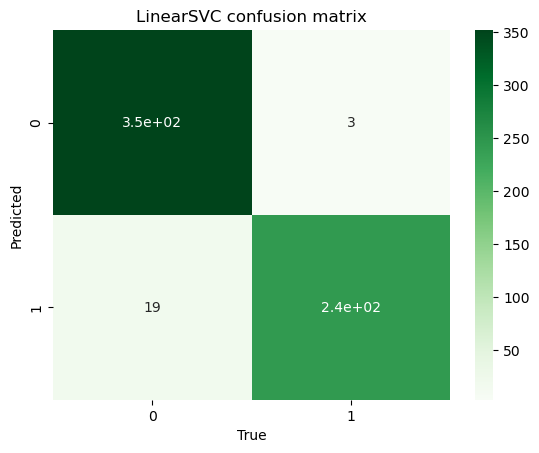

In [114]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LinearSVC confusion matrix')
plt.show()

In [115]:
net.model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               23200     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 43,602
Trainable params: 43,602
Non-trainable params: 0
_________________________________________________________________


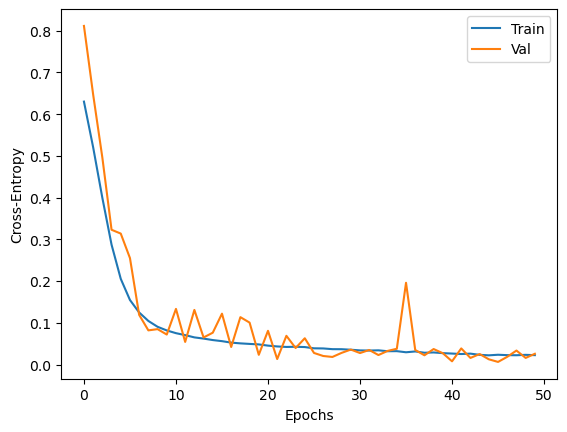

In [116]:
history = net.history_
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

20/20 [==============================] - 0s 2ms/step


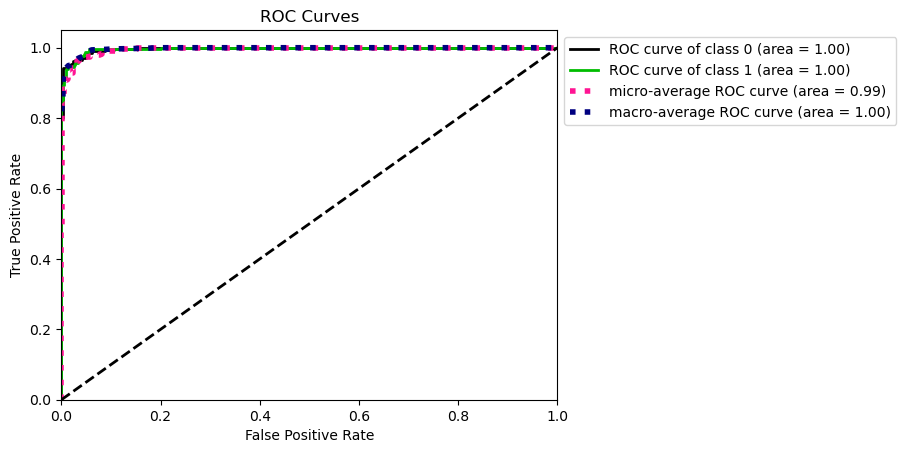

0.9967100311794431


In [117]:
y_test_pred_proba = net.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

# Ensemble methods

## Random Forest

In [118]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [119]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 200, 2000, 10)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',['auto', 'sqrt'])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               bootstrap=bootstrap, criterion=criterion)
    rf.fit(X_res_t, y_res_t)
    y_pred = rf.predict(X_res_v)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-06-12 11:49:58,922] A new study created in memory with name: no-name-ac9ef6e1-3643-4dee-a810-2c3074f86d21
[W 2023-06-12 11:50:05,312] Trial 7 failed with parameters: {'n_estimators': 1300, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 9, 'bootstrap': True, 'criterion': 'entropy'} because of the following error: ValueError('max_depth must be greater than zero. ').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\emanu\anacon

[I 2023-06-12 11:51:50,722] Trial 16 finished with value: 0.7991071428571429 and parameters: {'n_estimators': 760, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 1 with value: 0.8303571428571429.
[I 2023-06-12 11:51:53,272] Trial 15 finished with value: 0.8147321428571429 and parameters: {'n_estimators': 1290, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True, 'criterion': 'gini'}. Best is trial 1 with value: 0.8303571428571429.
[I 2023-06-12 11:51:55,272] Trial 17 finished with value: 0.8035714285714286 and parameters: {'n_estimators': 680, 'max_depth': 90, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 5, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 1 with value: 0.8303571428571429.
[I 2023-06-12 11:52:00,553] Trial 19 finished with value: 0.8392857142857143 and parameters: {'n_estimators': 690, 'm

[W 2023-06-12 11:52:15,262] Trial 29 failed with value None.
[W 2023-06-12 11:52:16,222] Trial 30 failed with parameters: {'n_estimators': 1500, 'max_depth': 80, 'max_features': 'auto', 'min_samples_split': 1, 'min_samples_leaf': 5, 'bootstrap': True, 'criterion': 'entropy'} because of the following error: ValueError('min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\emanu\

[W 2023-06-12 11:53:12,136] Trial 41 failed with value None.
[W 2023-06-12 11:53:12,751] Trial 42 failed with parameters: {'n_estimators': 890, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 15, 'min_samples_leaf': 9, 'bootstrap': True, 'criterion': 'entropy'} because of the following error: ValueError('max_depth must be greater than zero. ').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 901, 

[W 2023-06-12 11:53:16,415] Trial 46 failed with value None.
[I 2023-06-12 11:53:19,772] Trial 37 finished with value: 0.8191964285714286 and parameters: {'n_estimators': 850, 'max_depth': 40, 'max_features': 'auto', 'min_samples_split': 15, 'min_samples_leaf': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 39 with value: 0.8482142857142857.
[W 2023-06-12 11:53:20,441] Trial 48 failed with parameters: {'n_estimators': 940, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'entropy'} because of the following error: ValueError('max_depth must be greater than zero. ').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-

In [120]:
best_params = study.best_params

rf = RandomForestClassifier(**best_params)
rf.fit(X_res_t, y_res_t)

y_pred_test = rf.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'n_estimators': 590, 'max_depth': 60, 'max_features': 'auto', 'min_samples_split': 15, 'min_samples_leaf': 8, 'bootstrap': True, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       355
           1       1.00      0.87      0.93       262

    accuracy                           0.94       617
   macro avg       0.96      0.94      0.94       617
weighted avg       0.95      0.94      0.94       617

Accuracy 0.9448946515397083
F1-score [0.95430108 0.93061224]


In [ ]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LinearSVC confusion matrix')
plt.show()

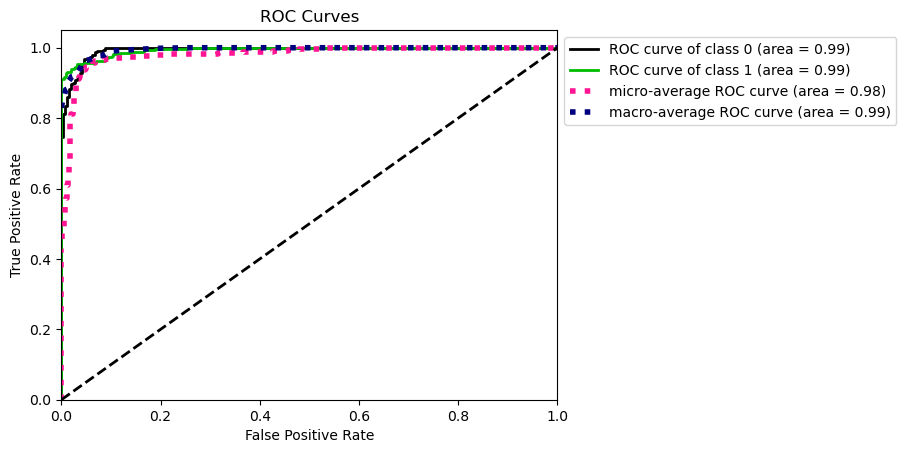

0.993678099129126


In [121]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc

y_test_pred_proba = rf.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

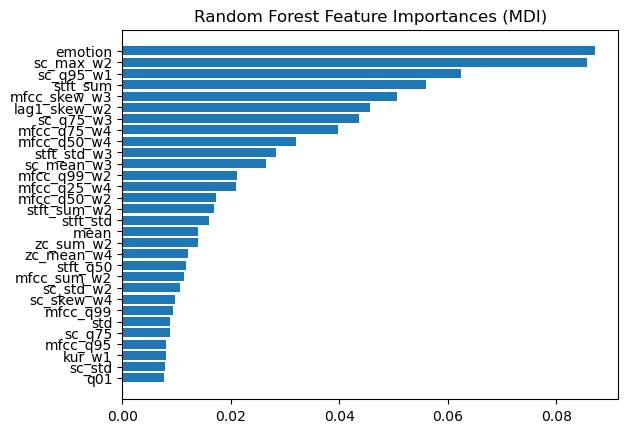

In [122]:
nbr_features = X_res_t.shape[1]

tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[::-1][:30]
df2 = df.iloc[:, sorted_idx]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx][::-1])
plt.yticks(y_ticks, list(df2.columns)[::-1])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

In [123]:
from sklearn.inspection import permutation_importance

In [124]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

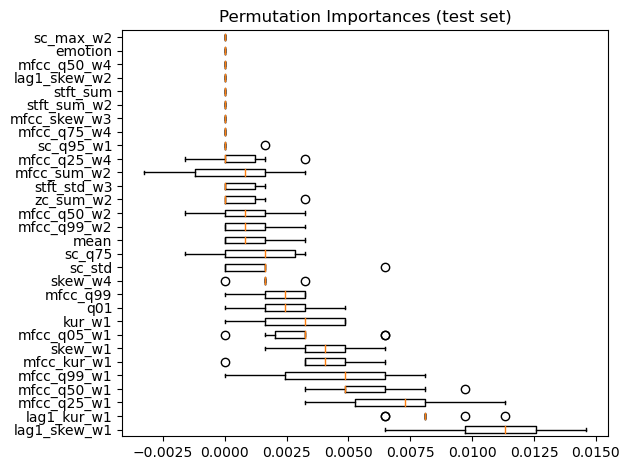

In [125]:
sorted_idx = result.importances_mean.argsort()[::-1][:30]
df2 = df.iloc[:, sorted_idx]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=list(df2.columns)[::-1])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [126]:
from sklearn.tree import plot_tree

In [127]:
rf.estimators_[0]

DecisionTreeClassifier(criterion='entropy', max_depth=60, max_features='auto',
                       min_samples_leaf=8, min_samples_split=15,
                       random_state=1331420557)

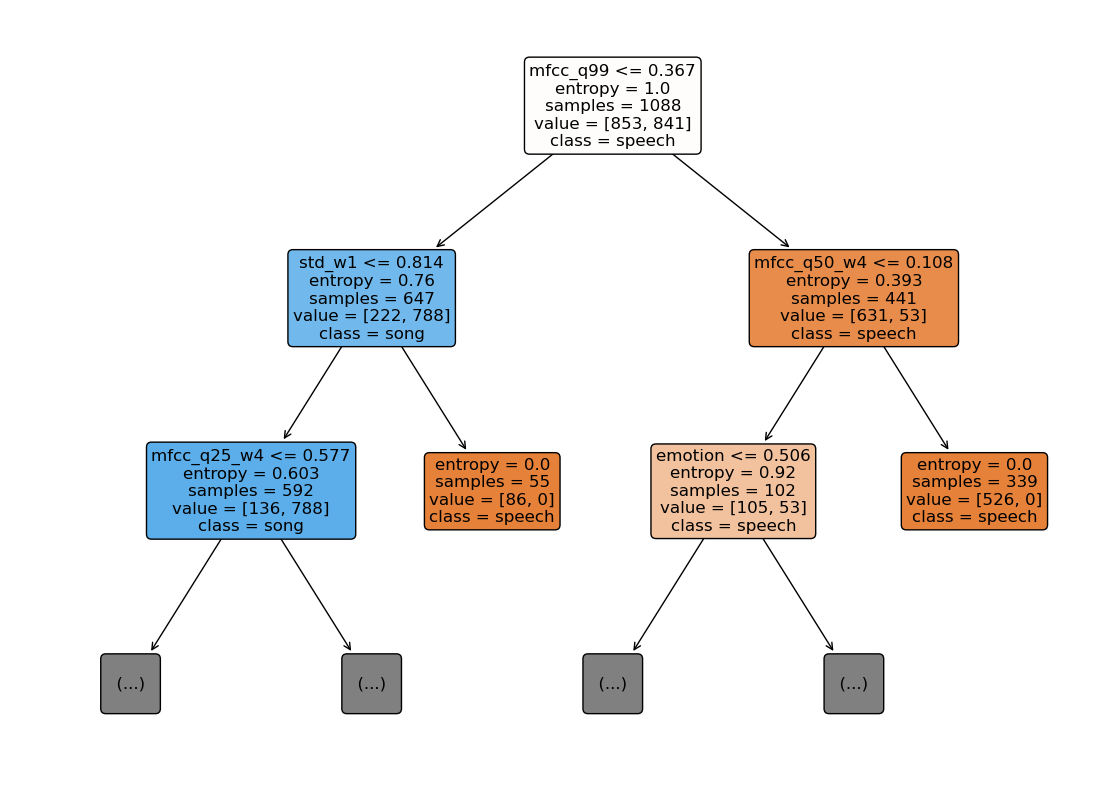

In [128]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[0], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

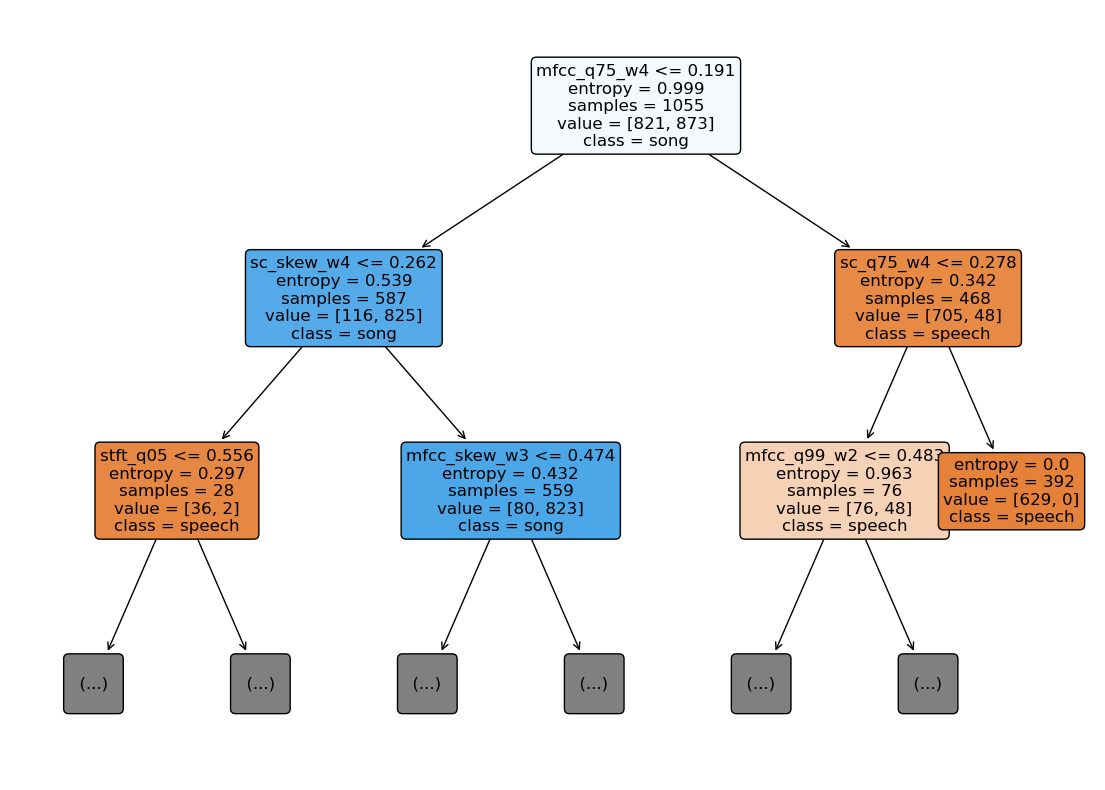

In [129]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[1], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

# Gradient Boosting

In [130]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [131]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 1, 20)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',["log2","sqrt"])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    criterion = trial.suggest_categorical('criterion', ["friedman_mse",  "mae"])
    subsample = trial.suggest_float('subsample', 0.5, 1)
    loss = trial.suggest_categorical('loss',['log_loss', 'deviance', 'exponential'])
                                  
                                          
    gb = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               learning_rate=learning_rate, criterion=criterion, subsample=subsample, loss=loss)
    gb.fit(X_res_t, y_res_t)
    y_pred = rf.predict(X_res_v)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 100, n_jobs = -1, catch=(ValueError,))

[I 2023-06-12 11:58:23,342] A new study created in memory with name: no-name-174a8476-20eb-4573-bc97-83a82ca8c516
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-12 11:58:23,383] Trial 0 failed with parameters: {'n_estimators': 19, 'max_depth': 40, 'max_features': 'log2', 'min_samples_split': 1, 'min_samples_leaf': 4, 'learning_rate': 0.030658735704684283, 'criterion': '

[W 2023-06-12 11:58:23,512] Trial 12 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-12 11:58:23,531] Trial 13 failed with parameters: {'n_estimators': 18, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.17495860538717847, 'criterion': 'mae', 'subsample': 0.6277427096233608, 'loss': 'deviance'} because of the following error: ValueError('max_depth must be greater than zero. ').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3961920590.p

[W 2023-06-12 11:58:24,720] Trial 18 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-12 11:58:24,736] Trial 19 failed with parameters: {'n_estimators': 16, 'max_depth': 80, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 5, 'learning_rate': 0.030963311384288927, 'criterion': 'mae', 'subsample': 0.5304731207259955, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3961920590.py", 

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
[W 2023-06-12 11:58:26,641] Trial 25 failed with parameters: {'n_estimators': 19, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 10, 'learning_rate': 0.03347390578041951, 'criterion': 'mae', 'subsample': 0.9629492243339342, 'loss': 'exponential'} because of the following error: ValueError('max_depth must be greater than zero. ').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 586, in fit
  

[W 2023-06-12 11:58:27,322] Trial 31 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be 

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-12 11:58:28,909] Trial 35 failed with parameters: {'n_estimators': 1, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 2, 'learning_rate': 0.21936990396841632, 'criterion': 'mae', 'subsample': 0.5111416016881237, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "

[W 2023-06-12 11:58:29,372] Trial 40 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-12 11:58:29,462] Trial 41 failed with parameters: {'n_estimators': 12, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 10, 'learning_rate': 0.21792250004711866, 'criterion': 'mae', 'subsample': 0.5099505792989252, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (m

[W 2023-06-12 11:58:29,977] Trial 46 failed with parameters: {'n_estimators': 12, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 1, 'learning_rate': 0.2144982315071141, 'criterion': 'mae', 'subsample': 0.8504189331445083, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 282, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'log_loss' not supported. 
[W

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-12 11:58:30,554] Trial 52 failed with parameters: {'n_estimators': 1, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 1, 'learning_rate': 0.21881107277233902, 'criterion': 'mae', 'subsample': 0.5097349281458732, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "

[W 2023-06-12 11:58:31,022] Trial 57 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-12 11:58:31,125] Trial 58 failed with parameters: {'n_estimators': 12, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 2, 'learning_rate': 0.22634769794356047, 'criterion': 'mae', 'subsample': 0.5068364522112425, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3961920590.py", l

[W 2023-06-12 11:58:31,605] Trial 63 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-12 11:58:31,692] Trial 64 failed with parameters: {'n_estimators': 1, 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 1, 'learning_rate': 0.22100996323701033, 'criterion': 'mae', 'subsample': 0.8565522724344303, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3961920590.py", 

[W 2023-06-12 11:58:32,185] Trial 69 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-12 11:58:32,270] Trial 70 failed with parameters: {'n_estimators': 1, 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 1, 'learning_rate': 0.21346741922975285, 'criterion': 'mae', 'subsample': 0.5213487325638543, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3961920590.py", 

[W 2023-06-12 11:58:32,753] Trial 75 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-12 11:58:32,841] Trial 76 failed with parameters: {'n_estimators': 1, 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 2, 'learning_rate': 0.21059012846635122, 'criterion': 'mae', 'subsample': 0.5020887092830038, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_20252\3961920590.py", 

[W 2023-06-12 11:58:33,292] Trial 81 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-12 11:58:33,375] Trial 82 failed with parameters: {'n_estimators': 1, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 1, 'learning_rate': 0.20664147149471254, 'criterion': 'mae', 'subsample': 0.513219652879277, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most

[W 2023-06-12 11:58:33,872] Trial 87 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-12 11:58:33,966] Trial 88 failed with parameters: {'n_estimators': 12, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 1, 'learning_rate': 0.21741692766014697, 'criterion': 'mae', 'subsample': 0.8560460385012227, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (mo

[W 2023-06-12 11:58:34,444] Trial 93 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
[W 2023-06-12 11:58:34,539] Trial 94 failed with parameters: {'n_estimators': 12, 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 1, 'learning_rate': 0.2234734813622168, 'criterion': 'mae', 'subsample': 0.8561421259081595, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (m

[W 2023-06-12 11:58:35,035] Trial 99 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
[I 2023-06-12 11:58:40,281] Trial 32 finished with value: 0.8191964285714286 and parameters: {'n_estimators': 8, 'max_depth': 90, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 5, 'learning_rate': 0.014281355824624586, 'criterion': 'mae', 'subsample': 0.8496581820151778, 'loss': 'exponential'}. Best is trial 8 with value: 0.8191964285714286.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use 

In [132]:
best_params = study.best_params

gb = GradientBoostingClassifier(**best_params)
gb.fit(X_res_t, y_res_t)

y_pred_test = gb.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'n_estimators': 7, 'max_depth': 40, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 5, 'learning_rate': 0.2600444817430603, 'criterion': 'friedman_mse', 'subsample': 0.7091901589157578, 'loss': 'exponential'}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       355
           1       0.98      0.75      0.85       262

    accuracy                           0.89       617
   macro avg       0.91      0.87      0.88       617
weighted avg       0.90      0.89      0.88       617

Accuracy 0.8865478119935171
F1-score [0.90932642 0.84848485]


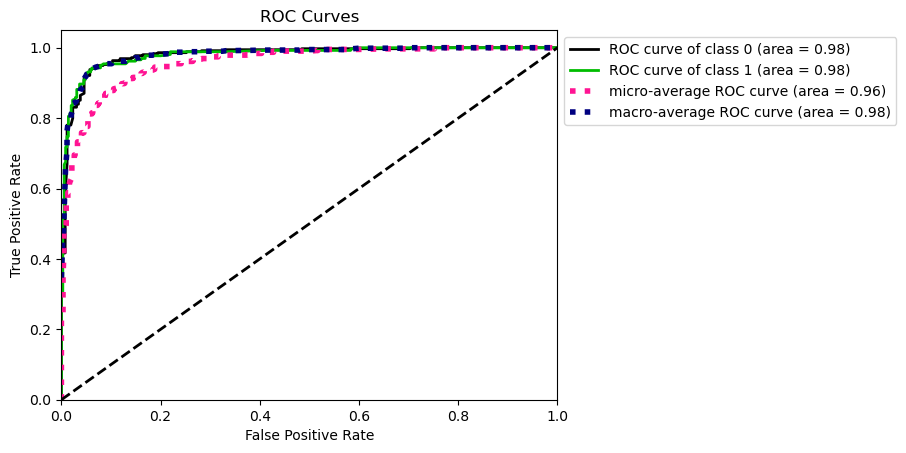

0.9794323191054725


In [133]:
y_test_pred_proba = gb.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))